### Import Libraries

In [1]:
#Set few things up for autoreloading and graph plotting
%load_ext autoreload
%autoreload 2

%pylab inline
%config InlineBackend.figbure_format = 'retina'
sys.path.append("./src")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import tqdm
import numpy as np
import networkx as nx
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, TensorDataset, DataLoader

In [3]:
from database import *
from model import *
from utils import *
from train import *

### Set seeds and GPU

In [4]:
nxseed = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
np.random.seed(5)
torch.manual_seed(5)
if device is not "cpu":
    torch.cuda.manual_seed(5)

In [5]:
def plotgraph(results):
    cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))
    columns = {v:k for k,v in enumerate(['n','layers','units','val_acc','activation'])}
    full_res = []

    for node in results.keys():
        for layer in results[node].keys():
            for unit in results[node][layer].keys():
                l = [None]*len(columns)
                l[columns['n']] = node
                l[columns['layers']] = layer
                l[columns['units']] = unit
                l[columns['val_acc']] = max(results[node][layer][unit]['val_accuracy'])
                l[columns['activation']] = "linear"
                full_res.append(l)

    full_res = np.array(full_res)
    s = set(full_res[:, columns['activation']])
    results = {a: np.float32(full_res[np.where(full_res[:, columns['activation']]==a)[0], :-1]) for a in s}

    r = results['linear']
    stats = {}
    for l in set(r[:,columns['layers']]):
        for u in set(r[:,columns['units']]):
            ix = np.where((r[:,columns['layers']]==l) * (r[:,columns['units']]==u))[0]
            k = (l,u)
            stats[k] = r[ix][:,[columns['n'],columns['val_acc']]]

    figure(figsize=(10,6))
    for k in sorted(stats):
        a = array(stats[k])
        l,u = k
        if l==5: continue
        plot(*a[argsort(a[:,0])].T, label = 'L=%d, u=%d' %k, lw=1.2*u**1.2 , alpha= 1-tanh(u/10), c = cols[l])

    legend(ncol = 4,fontsize=12)
    xlabel('# of nodes in graph', size = 14)    
    ylabel('Test Accuracy',size = 14)

    t = ('BA vs ER' )
    title('Accuracy of GCN modular architectures in classifying %s'%(t),size=16 )
    grid()
    tight_layout()

In [10]:
class ModifiedModularGCN(nn.Module):
    '''
    Modified Modular GCN for the prediction of topology
    Attributes:
        modulargcn(Object of class ModularGCN) : The GCN Layers for the training.
        finaldense(Object of class nn.Linear) : The final dense layer to produce the class label length output for the categorical cross
        entropy to work.
        params(dict) : Parameters for the ModularGCN object
        outputnodefeat(int) : Feature size of the deep node representation
        labelsize(int) : Size of the labels of the final output
    '''
    def __init__(self, labelsize, paramsformodularmodulargcn):
        '''Constructor for the final layer class'''
        super(ModifiedModularGCN, self).__init__()
        self.labelsize = labelsize
        self.params = paramsformodularmodulargcn
        self.modulargcn = ModularGCN(params["inputnodefeat"], params["outputnodefeat"], params["units"], params["activation"], params["skip"]).to(device)
        self.finaldense = nn.Linear(params["outputnodefeat"], labelsize).to(device)
    def forward(self, adj, h):
        '''Forward operation of the layer'''
        outputnodelevelfeat = self.modulargcn(adj, h)
        outputnodelevelfeat = self.finaldense(outputnodelevelfeat)
        outputnodelevelclass = F.softmax(outputnodelevelfeat, -1)
        graphlevelclass = outputnodelevelclass.mean(-2)
        return graphlevelclass

## BA vs ER

In [11]:
#Generate the map dataset for BA vs ER
def generate_BAvsER(params):
    map_dict = {"BA" : 1, "ER": 0}
    n_classes = len(map_dict)

    graphdatabase = GraphData(params["n_samples"], params["nodes"])
    graphdatabase.generate_BAGraphs()
    graphdatabase.generate_ERGraphs()
    graphdatabase.generate_adjs()
    graphdatabase.tokenise(map_dict)
    
    ADJ = np.array(shuffle_graphadjs(graphdatabase.graphadjs))
    Y = np.expand_dims(np.array(graphdatabase.tokenisedgraphlabels), axis = 1)
    h = np.ones(ADJ.shape[:2]+(1,))
    return ADJ, Y, h

In [15]:
nodes = [10, 20, 30, 50]
layers = [1,2,3,4]
units = [1, 3, 5]
results = {}

for node in nodes:
    results[node] = {}
    print("Current node is :", node)
    for layer in layers:
        results[node][layer] = {}
        for unit in units:
            results[node][layer][unit] = {}
            print("Working for Nodes :", node, ", Layers :", layer, " and Units", unit)
            
            #Make the parameters for the model and the data
            params = {"n_samples" : 2500,
                  "nodes" : node,
                  "units" : [unit]*layer,
                  "activation" : "linear",
                  "outputnodefeat" : 10,
                  "inputnodefeat" : 1, 
                  "skip" : True}
            
            #Generate the data
            ADJ, Y, h = generate_BAvsER(params)
            #Make the model
            net = ModifiedModularGCN(2, params)
            
            #Define the loss function
            loss_fn = nn.CrossEntropyLoss()
            #Define the optimiser
            optimizer = optim.Adam(net.parameters(), lr=.001)
            #Define the training step to train the model
            train_step = make_train_step(net, loss_fn, optimizer)
            #Make the dataloader
            train_loader, val_loader = make_loader([ADJ, h], Y, None, .2)
            #Train the model
            training_losses, validation_losses, training_accuracy, validation_accuracy = \
            train_model(net, device, train_step, loss_fn, 200, train_loader, val_loader)
            
            #Save the model results
            results[node][layer][unit] = {"loss": training_losses, "val_loss" :validation_losses, \
                                  "train_accuracy": training_accuracy, "val_accuracy": validation_accuracy}

Current node is : 10
Working for Nodes : 10 , Layers : 1  and Units 1
[1] Training loss: 0.698724	 Validation loss: 0.699967
[1] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[2] Training loss: 0.698393	 Validation loss: 0.699590
[2] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[3] Training loss: 0.698072	 Validation loss: 0.699225
[3] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[4] Training loss: 0.697764	 Validation loss: 0.698871
[4] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[5] Training loss: 0.697466	 Validation loss: 0.698529
[5] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[6] Training loss: 0.697180	 Validation loss: 0.698198
[6] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[7] Training loss: 0.696905	 Validation loss: 0.697880
[7] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[8] Training loss: 0.696642	 Validation loss: 0.697574
[8] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[9] Training loss: 0.696390	 Valid

[72] Training loss: 0.692301	 Validation loss: 0.692333
[72] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[73] Training loss: 0.692268	 Validation loss: 0.692304
[73] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[74] Training loss: 0.692234	 Validation loss: 0.692275
[74] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[75] Training loss: 0.692199	 Validation loss: 0.692244
[75] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[76] Training loss: 0.692163	 Validation loss: 0.692212
[76] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[77] Training loss: 0.692125	 Validation loss: 0.692178
[77] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[78] Training loss: 0.692087	 Validation loss: 0.692142
[78] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[79] Training loss: 0.692047	 Validation loss: 0.692105
[79] Training Accuracy: 0.502	 Validation Accuracy: 0.492
[80] Training loss: 0.692005	 Validation loss: 0.692066
[80] Training Accuracy: 0.502	 V

[143] Training loss: 0.669939	 Validation loss: 0.669007
[143] Training Accuracy: 0.576	 Validation Accuracy: 0.570
[144] Training loss: 0.668970	 Validation loss: 0.667994
[144] Training Accuracy: 0.576	 Validation Accuracy: 0.570
[145] Training loss: 0.667976	 Validation loss: 0.666954
[145] Training Accuracy: 0.576	 Validation Accuracy: 0.570
[146] Training loss: 0.666958	 Validation loss: 0.665888
[146] Training Accuracy: 0.576	 Validation Accuracy: 0.570
[147] Training loss: 0.665913	 Validation loss: 0.664795
[147] Training Accuracy: 0.576	 Validation Accuracy: 0.570
[148] Training loss: 0.664843	 Validation loss: 0.663672
[148] Training Accuracy: 0.576	 Validation Accuracy: 0.570
[149] Training loss: 0.663744	 Validation loss: 0.662522
[149] Training Accuracy: 0.576	 Validation Accuracy: 0.570
[150] Training loss: 0.662618	 Validation loss: 0.661346
[150] Training Accuracy: 0.576	 Validation Accuracy: 0.570
[151] Training loss: 0.661469	 Validation loss: 0.660320
[151] Training 

[13] Training Accuracy: 0.298	 Validation Accuracy: 0.301
[14] Training loss: 0.701997	 Validation loss: 0.701086
[14] Training Accuracy: 0.239	 Validation Accuracy: 0.231
[15] Training loss: 0.701129	 Validation loss: 0.700198
[15] Training Accuracy: 0.198	 Validation Accuracy: 0.193
[16] Training loss: 0.700274	 Validation loss: 0.699324
[16] Training Accuracy: 0.126	 Validation Accuracy: 0.123
[17] Training loss: 0.699431	 Validation loss: 0.698462
[17] Training Accuracy: 0.126	 Validation Accuracy: 0.123
[18] Training loss: 0.698598	 Validation loss: 0.697608
[18] Training Accuracy: 0.002	 Validation Accuracy: 0.001
[19] Training loss: 0.697771	 Validation loss: 0.696760
[19] Training Accuracy: 0.374	 Validation Accuracy: 0.386
[20] Training loss: 0.696948	 Validation loss: 0.695925
[20] Training Accuracy: 0.374	 Validation Accuracy: 0.386
[21] Training loss: 0.696136	 Validation loss: 0.695107
[21] Training Accuracy: 0.373	 Validation Accuracy: 0.385
[22] Training loss: 0.695339	 

[85] Training loss: 0.628116	 Validation loss: 0.625567
[85] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[86] Training loss: 0.626572	 Validation loss: 0.624032
[86] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[87] Training loss: 0.625042	 Validation loss: 0.622534
[87] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[88] Training loss: 0.623548	 Validation loss: 0.621063
[88] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[89] Training loss: 0.622079	 Validation loss: 0.619688
[89] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[90] Training loss: 0.620700	 Validation loss: 0.618349
[90] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[91] Training loss: 0.619353	 Validation loss: 0.617003
[91] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[92] Training loss: 0.618000	 Validation loss: 0.615654
[92] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[93] Training loss: 0.616642	 Validation loss: 0.614300
[93] Training Accuracy: 0.677	 V

[155] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[156] Training loss: 0.527716	 Validation loss: 0.526399
[156] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[157] Training loss: 0.526416	 Validation loss: 0.525106
[157] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[158] Training loss: 0.525120	 Validation loss: 0.523813
[158] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[159] Training loss: 0.523825	 Validation loss: 0.522520
[159] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[160] Training loss: 0.522533	 Validation loss: 0.521243
[160] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[161] Training loss: 0.521258	 Validation loss: 0.519972
[161] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[162] Training loss: 0.519989	 Validation loss: 0.518715
[162] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[163] Training loss: 0.518736	 Validation loss: 0.517468
[163] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[164] Trainin

[26] Training loss: 0.708187	 Validation loss: 0.694695
[26] Training Accuracy: 0.493	 Validation Accuracy: 0.528
[27] Training loss: 0.706703	 Validation loss: 0.693411
[27] Training Accuracy: 0.493	 Validation Accuracy: 0.528
[28] Training loss: 0.705216	 Validation loss: 0.692119
[28] Training Accuracy: 0.493	 Validation Accuracy: 0.528
[29] Training loss: 0.703722	 Validation loss: 0.689859
[29] Training Accuracy: 0.493	 Validation Accuracy: 0.528
[30] Training loss: 0.701234	 Validation loss: 0.687100
[30] Training Accuracy: 0.493	 Validation Accuracy: 0.528
[31] Training loss: 0.698230	 Validation loss: 0.685017
[31] Training Accuracy: 0.493	 Validation Accuracy: 0.528
[32] Training loss: 0.695913	 Validation loss: 0.682958
[32] Training Accuracy: 0.493	 Validation Accuracy: 0.528
[33] Training loss: 0.693618	 Validation loss: 0.680868
[33] Training Accuracy: 0.493	 Validation Accuracy: 0.528
[34] Training loss: 0.691289	 Validation loss: 0.678747
[34] Training Accuracy: 0.493	 V

[97] Training Accuracy: 0.673	 Validation Accuracy: 0.685
[98] Training loss: 0.607331	 Validation loss: 0.602638
[98] Training Accuracy: 0.673	 Validation Accuracy: 0.685
[99] Training loss: 0.606383	 Validation loss: 0.601578
[99] Training Accuracy: 0.673	 Validation Accuracy: 0.685
[100] Training loss: 0.605433	 Validation loss: 0.600513
[100] Training Accuracy: 0.673	 Validation Accuracy: 0.685
[101] Training loss: 0.604481	 Validation loss: 0.599447
[101] Training Accuracy: 0.673	 Validation Accuracy: 0.685
[102] Training loss: 0.603528	 Validation loss: 0.598378
[102] Training Accuracy: 0.673	 Validation Accuracy: 0.685
[103] Training loss: 0.602569	 Validation loss: 0.597303
[103] Training Accuracy: 0.673	 Validation Accuracy: 0.685
[104] Training loss: 0.601606	 Validation loss: 0.596218
[104] Training Accuracy: 0.673	 Validation Accuracy: 0.685
[105] Training loss: 0.600636	 Validation loss: 0.595120
[105] Training Accuracy: 0.673	 Validation Accuracy: 0.685
[106] Training los

[168] Training loss: 0.516642	 Validation loss: 0.500345
[168] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[169] Training loss: 0.515331	 Validation loss: 0.498900
[169] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[170] Training loss: 0.514031	 Validation loss: 0.497474
[170] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[171] Training loss: 0.512743	 Validation loss: 0.496066
[171] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[172] Training loss: 0.511466	 Validation loss: 0.494675
[172] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[173] Training loss: 0.510200	 Validation loss: 0.493302
[173] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[174] Training loss: 0.508944	 Validation loss: 0.491945
[174] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[175] Training loss: 0.507699	 Validation loss: 0.490605
[175] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[176] Training loss: 0.506466	 Validation loss: 0.489281
[176] Training 

[39] Training loss: 0.681160	 Validation loss: 0.680911
[39] Training Accuracy: 0.502	 Validation Accuracy: 0.490
[40] Training loss: 0.680459	 Validation loss: 0.680209
[40] Training Accuracy: 0.502	 Validation Accuracy: 0.490
[41] Training loss: 0.679772	 Validation loss: 0.679550
[41] Training Accuracy: 0.502	 Validation Accuracy: 0.490
[42] Training loss: 0.679127	 Validation loss: 0.678807
[42] Training Accuracy: 0.502	 Validation Accuracy: 0.490
[43] Training loss: 0.678393	 Validation loss: 0.678141
[43] Training Accuracy: 0.502	 Validation Accuracy: 0.490
[44] Training loss: 0.677736	 Validation loss: 0.677461
[44] Training Accuracy: 0.516	 Validation Accuracy: 0.509
[45] Training loss: 0.677065	 Validation loss: 0.676765
[45] Training Accuracy: 0.552	 Validation Accuracy: 0.545
[46] Training loss: 0.676379	 Validation loss: 0.676054
[46] Training Accuracy: 0.679	 Validation Accuracy: 0.650
[47] Training loss: 0.675679	 Validation loss: 0.675327
[47] Training Accuracy: 0.822	 V

[110] Training Accuracy: 0.871	 Validation Accuracy: 0.874
[111] Training loss: 0.558330	 Validation loss: 0.555203
[111] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[112] Training loss: 0.555842	 Validation loss: 0.552644
[112] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[113] Training loss: 0.553353	 Validation loss: 0.550195
[113] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[114] Training loss: 0.550977	 Validation loss: 0.547848
[114] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[115] Training loss: 0.548702	 Validation loss: 0.545449
[115] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[116] Training loss: 0.546371	 Validation loss: 0.543010
[116] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[117] Training loss: 0.543996	 Validation loss: 0.540543
[117] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[118] Training loss: 0.541590	 Validation loss: 0.538060
[118] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[119] Trainin

[181] Training loss: 0.437379	 Validation loss: 0.432577
[181] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[182] Training loss: 0.436719	 Validation loss: 0.431921
[182] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[183] Training loss: 0.436072	 Validation loss: 0.431279
[183] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[184] Training loss: 0.435440	 Validation loss: 0.430652
[184] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[185] Training loss: 0.434820	 Validation loss: 0.430040
[185] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[186] Training loss: 0.434215	 Validation loss: 0.429440
[186] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[187] Training loss: 0.433622	 Validation loss: 0.428850
[187] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[188] Training loss: 0.433036	 Validation loss: 0.428267
[188] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[189] Training loss: 0.432460	 Validation loss: 0.427692
[189] Training 

[52] Training loss: 0.674436	 Validation loss: 0.675184
[52] Training Accuracy: 0.380	 Validation Accuracy: 0.360
[53] Training loss: 0.673434	 Validation loss: 0.674270
[53] Training Accuracy: 0.380	 Validation Accuracy: 0.360
[54] Training loss: 0.672420	 Validation loss: 0.673342
[54] Training Accuracy: 0.380	 Validation Accuracy: 0.360
[55] Training loss: 0.671392	 Validation loss: 0.672397
[55] Training Accuracy: 0.379	 Validation Accuracy: 0.359
[56] Training loss: 0.670347	 Validation loss: 0.671434
[56] Training Accuracy: 0.379	 Validation Accuracy: 0.359
[57] Training loss: 0.669285	 Validation loss: 0.670452
[57] Training Accuracy: 0.379	 Validation Accuracy: 0.359
[58] Training loss: 0.668204	 Validation loss: 0.669450
[58] Training Accuracy: 0.379	 Validation Accuracy: 0.359
[59] Training loss: 0.667101	 Validation loss: 0.668426
[59] Training Accuracy: 0.379	 Validation Accuracy: 0.359
[60] Training loss: 0.665978	 Validation loss: 0.667380
[60] Training Accuracy: 0.379	 V

[123] Training loss: 0.563821	 Validation loss: 0.567612
[123] Training Accuracy: 0.775	 Validation Accuracy: 0.774
[124] Training loss: 0.561684	 Validation loss: 0.565500
[124] Training Accuracy: 0.775	 Validation Accuracy: 0.774
[125] Training loss: 0.559560	 Validation loss: 0.563360
[125] Training Accuracy: 0.775	 Validation Accuracy: 0.774
[126] Training loss: 0.557402	 Validation loss: 0.561081
[126] Training Accuracy: 0.783	 Validation Accuracy: 0.781
[127] Training loss: 0.555113	 Validation loss: 0.558761
[127] Training Accuracy: 0.799	 Validation Accuracy: 0.793
[128] Training loss: 0.552782	 Validation loss: 0.556391
[128] Training Accuracy: 0.828	 Validation Accuracy: 0.819
[129] Training loss: 0.550404	 Validation loss: 0.553970
[129] Training Accuracy: 0.859	 Validation Accuracy: 0.853
[130] Training loss: 0.547973	 Validation loss: 0.551492
[130] Training Accuracy: 0.871	 Validation Accuracy: 0.862
[131] Training loss: 0.545486	 Validation loss: 0.548965
[131] Training 

[193] Training Accuracy: 0.877	 Validation Accuracy: 0.867
[194] Training loss: 0.424274	 Validation loss: 0.430969
[194] Training Accuracy: 0.877	 Validation Accuracy: 0.867
[195] Training loss: 0.423614	 Validation loss: 0.430299
[195] Training Accuracy: 0.877	 Validation Accuracy: 0.867
[196] Training loss: 0.422960	 Validation loss: 0.429639
[196] Training Accuracy: 0.877	 Validation Accuracy: 0.867
[197] Training loss: 0.422318	 Validation loss: 0.428977
[197] Training Accuracy: 0.877	 Validation Accuracy: 0.867
[198] Training loss: 0.421676	 Validation loss: 0.428311
[198] Training Accuracy: 0.877	 Validation Accuracy: 0.867
[199] Training loss: 0.421032	 Validation loss: 0.427641
[199] Training Accuracy: 0.877	 Validation Accuracy: 0.867
[200] Training loss: 0.420385	 Validation loss: 0.426965
[200] Training Accuracy: 0.877	 Validation Accuracy: 0.867
Working for Nodes : 10 , Layers : 2  and Units 5
[1] Training loss: 0.721730	 Validation loss: 0.714931
[1] Training Accuracy: 0.

[64] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[65] Training loss: 0.602209	 Validation loss: 0.598089
[65] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[66] Training loss: 0.599526	 Validation loss: 0.595643
[66] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[67] Training loss: 0.597120	 Validation loss: 0.593119
[67] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[68] Training loss: 0.594634	 Validation loss: 0.590463
[68] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[69] Training loss: 0.592015	 Validation loss: 0.587684
[69] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[70] Training loss: 0.589273	 Validation loss: 0.584848
[70] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[71] Training loss: 0.586473	 Validation loss: 0.581983
[71] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[72] Training loss: 0.583646	 Validation loss: 0.579129
[72] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[73] Training loss: 0.580832	 

[135] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[136] Training loss: 0.437755	 Validation loss: 0.430271
[136] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[137] Training loss: 0.436171	 Validation loss: 0.428711
[137] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[138] Training loss: 0.434586	 Validation loss: 0.427138
[138] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[139] Training loss: 0.432997	 Validation loss: 0.425557
[139] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[140] Training loss: 0.431393	 Validation loss: 0.423947
[140] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[141] Training loss: 0.429755	 Validation loss: 0.422316
[141] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[142] Training loss: 0.428091	 Validation loss: 0.420664
[142] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[143] Training loss: 0.426397	 Validation loss: 0.419002
[143] Training Accuracy: 0.873	 Validation Accuracy: 0.884
[144] Trainin

[5] Training Accuracy: 0.505	 Validation Accuracy: 0.481
[6] Training loss: 0.703900	 Validation loss: 0.707468
[6] Training Accuracy: 0.505	 Validation Accuracy: 0.481
[7] Training loss: 0.702207	 Validation loss: 0.705565
[7] Training Accuracy: 0.505	 Validation Accuracy: 0.481
[8] Training loss: 0.700427	 Validation loss: 0.703554
[8] Training Accuracy: 0.505	 Validation Accuracy: 0.481
[9] Training loss: 0.698548	 Validation loss: 0.701429
[9] Training Accuracy: 0.505	 Validation Accuracy: 0.481
[10] Training loss: 0.696562	 Validation loss: 0.699183
[10] Training Accuracy: 0.505	 Validation Accuracy: 0.481
[11] Training loss: 0.694462	 Validation loss: 0.696811
[11] Training Accuracy: 0.505	 Validation Accuracy: 0.481
[12] Training loss: 0.692243	 Validation loss: 0.694303
[12] Training Accuracy: 0.505	 Validation Accuracy: 0.481
[13] Training loss: 0.689897	 Validation loss: 0.692032
[13] Training Accuracy: 0.505	 Validation Accuracy: 0.481
[14] Training loss: 0.687780	 Validatio

[77] Training loss: 0.500658	 Validation loss: 0.496770
[77] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[78] Training loss: 0.497685	 Validation loss: 0.494063
[78] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[79] Training loss: 0.494777	 Validation loss: 0.491425
[79] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[80] Training loss: 0.491939	 Validation loss: 0.488869
[80] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[81] Training loss: 0.489185	 Validation loss: 0.486389
[81] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[82] Training loss: 0.486512	 Validation loss: 0.483975
[82] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[83] Training loss: 0.483913	 Validation loss: 0.481624
[83] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[84] Training loss: 0.481383	 Validation loss: 0.479331
[84] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[85] Training loss: 0.478919	 Validation loss: 0.477096
[85] Training Accuracy: 0.876	 V

[148] Training loss: 0.410152	 Validation loss: 0.413228
[148] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[149] Training loss: 0.409647	 Validation loss: 0.412718
[149] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[150] Training loss: 0.409141	 Validation loss: 0.412205
[150] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[151] Training loss: 0.408634	 Validation loss: 0.411691
[151] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[152] Training loss: 0.408125	 Validation loss: 0.411174
[152] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[153] Training loss: 0.407614	 Validation loss: 0.410654
[153] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[154] Training loss: 0.407102	 Validation loss: 0.410131
[154] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[155] Training loss: 0.406587	 Validation loss: 0.409605
[155] Training Accuracy: 0.876	 Validation Accuracy: 0.870
[156] Training loss: 0.406070	 Validation loss: 0.409076
[156] Training 

[18] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[19] Training loss: 0.665331	 Validation loss: 0.662289
[19] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[20] Training loss: 0.663720	 Validation loss: 0.660613
[20] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[21] Training loss: 0.662063	 Validation loss: 0.658881
[21] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[22] Training loss: 0.660350	 Validation loss: 0.657090
[22] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[23] Training loss: 0.658576	 Validation loss: 0.655236
[23] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[24] Training loss: 0.656738	 Validation loss: 0.653317
[24] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[25] Training loss: 0.654834	 Validation loss: 0.651333
[25] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[26] Training loss: 0.652864	 Validation loss: 0.649282
[26] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[27] Training loss: 0.650826	 

[90] Training loss: 0.465813	 Validation loss: 0.464812
[90] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[91] Training loss: 0.463539	 Validation loss: 0.462671
[91] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[92] Training loss: 0.461338	 Validation loss: 0.460612
[92] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[93] Training loss: 0.459217	 Validation loss: 0.458631
[93] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[94] Training loss: 0.457176	 Validation loss: 0.456721
[94] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[95] Training loss: 0.455208	 Validation loss: 0.454881
[95] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[96] Training loss: 0.453311	 Validation loss: 0.453110
[96] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[97] Training loss: 0.451483	 Validation loss: 0.451404
[97] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[98] Training loss: 0.449724	 Validation loss: 0.449763
[98] Training Accuracy: 0.876	 V

[160] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[161] Training loss: 0.407304	 Validation loss: 0.409000
[161] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[162] Training loss: 0.406750	 Validation loss: 0.408421
[162] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[163] Training loss: 0.406186	 Validation loss: 0.407831
[163] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[164] Training loss: 0.405613	 Validation loss: 0.407230
[164] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[165] Training loss: 0.405029	 Validation loss: 0.406618
[165] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[166] Training loss: 0.404435	 Validation loss: 0.405995
[166] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[167] Training loss: 0.403829	 Validation loss: 0.405354
[167] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[168] Training loss: 0.403207	 Validation loss: 0.404694
[168] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[169] Trainin

[31] Training loss: 0.593592	 Validation loss: 0.595159
[31] Training Accuracy: 0.693	 Validation Accuracy: 0.676
[32] Training loss: 0.590276	 Validation loss: 0.591766
[32] Training Accuracy: 0.702	 Validation Accuracy: 0.683
[33] Training loss: 0.586939	 Validation loss: 0.588318
[33] Training Accuracy: 0.719	 Validation Accuracy: 0.710
[34] Training loss: 0.583568	 Validation loss: 0.584790
[34] Training Accuracy: 0.629	 Validation Accuracy: 0.629
[35] Training loss: 0.580136	 Validation loss: 0.581146
[35] Training Accuracy: 0.652	 Validation Accuracy: 0.653
[36] Training loss: 0.576608	 Validation loss: 0.577340
[36] Training Accuracy: 0.665	 Validation Accuracy: 0.673
[37] Training loss: 0.572940	 Validation loss: 0.573348
[37] Training Accuracy: 0.672	 Validation Accuracy: 0.679
[38] Training loss: 0.569109	 Validation loss: 0.569127
[38] Training Accuracy: 0.674	 Validation Accuracy: 0.682
[39] Training loss: 0.565069	 Validation loss: 0.564642
[39] Training Accuracy: 0.697	 V

[102] Training Accuracy: 0.874	 Validation Accuracy: 0.879
[103] Training loss: 0.386377	 Validation loss: 0.383311
[103] Training Accuracy: 0.874	 Validation Accuracy: 0.879
[104] Training loss: 0.385803	 Validation loss: 0.382756
[104] Training Accuracy: 0.874	 Validation Accuracy: 0.879
[105] Training loss: 0.385227	 Validation loss: 0.382199
[105] Training Accuracy: 0.874	 Validation Accuracy: 0.879
[106] Training loss: 0.384650	 Validation loss: 0.381641
[106] Training Accuracy: 0.874	 Validation Accuracy: 0.879
[107] Training loss: 0.384070	 Validation loss: 0.381082
[107] Training Accuracy: 0.874	 Validation Accuracy: 0.879
[108] Training loss: 0.383490	 Validation loss: 0.380521
[108] Training Accuracy: 0.874	 Validation Accuracy: 0.879
[109] Training loss: 0.382907	 Validation loss: 0.379959
[109] Training Accuracy: 0.874	 Validation Accuracy: 0.879
[110] Training loss: 0.382323	 Validation loss: 0.379395
[110] Training Accuracy: 0.874	 Validation Accuracy: 0.879
[111] Trainin

[173] Training loss: 0.350280	 Validation loss: 0.348657
[173] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[174] Training loss: 0.349901	 Validation loss: 0.348290
[174] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[175] Training loss: 0.349523	 Validation loss: 0.347925
[175] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[176] Training loss: 0.349146	 Validation loss: 0.347561
[176] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[177] Training loss: 0.348770	 Validation loss: 0.347198
[177] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[178] Training loss: 0.348396	 Validation loss: 0.346836
[178] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[179] Training loss: 0.348022	 Validation loss: 0.346475
[179] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[180] Training loss: 0.347649	 Validation loss: 0.346115
[180] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[181] Training loss: 0.347278	 Validation loss: 0.345756
[181] Training 

[44] Training loss: 0.622401	 Validation loss: 0.620541
[44] Training Accuracy: 0.773	 Validation Accuracy: 0.784
[45] Training loss: 0.618977	 Validation loss: 0.617109
[45] Training Accuracy: 0.773	 Validation Accuracy: 0.784
[46] Training loss: 0.615482	 Validation loss: 0.613708
[46] Training Accuracy: 0.773	 Validation Accuracy: 0.784
[47] Training loss: 0.612024	 Validation loss: 0.610310
[47] Training Accuracy: 0.773	 Validation Accuracy: 0.784
[48] Training loss: 0.608573	 Validation loss: 0.606863
[48] Training Accuracy: 0.773	 Validation Accuracy: 0.784
[49] Training loss: 0.605076	 Validation loss: 0.603368
[49] Training Accuracy: 0.773	 Validation Accuracy: 0.784
[50] Training loss: 0.601537	 Validation loss: 0.599839
[50] Training Accuracy: 0.773	 Validation Accuracy: 0.784
[51] Training loss: 0.597966	 Validation loss: 0.596337
[51] Training Accuracy: 0.773	 Validation Accuracy: 0.784
[52] Training loss: 0.594431	 Validation loss: 0.592805
[52] Training Accuracy: 0.773	 V

[115] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[116] Training loss: 0.439443	 Validation loss: 0.438805
[116] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[117] Training loss: 0.438635	 Validation loss: 0.438029
[117] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[118] Training loss: 0.437861	 Validation loss: 0.437286
[118] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[119] Training loss: 0.437121	 Validation loss: 0.436575
[119] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[120] Training loss: 0.436412	 Validation loss: 0.435894
[120] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[121] Training loss: 0.435733	 Validation loss: 0.435241
[121] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[122] Training loss: 0.435081	 Validation loss: 0.434615
[122] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[123] Training loss: 0.434456	 Validation loss: 0.434013
[123] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[124] Trainin

[186] Training loss: 0.406037	 Validation loss: 0.405645
[186] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[187] Training loss: 0.405374	 Validation loss: 0.404970
[187] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[188] Training loss: 0.404695	 Validation loss: 0.404280
[188] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[189] Training loss: 0.404001	 Validation loss: 0.403574
[189] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[190] Training loss: 0.403291	 Validation loss: 0.402852
[190] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[191] Training loss: 0.402564	 Validation loss: 0.402114
[191] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[192] Training loss: 0.401822	 Validation loss: 0.401359
[192] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[193] Training loss: 0.401063	 Validation loss: 0.400587
[193] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[194] Training loss: 0.400286	 Validation loss: 0.399799
[194] Training 

[57] Training loss: 0.564071	 Validation loss: 0.559522
[57] Training Accuracy: 0.771	 Validation Accuracy: 0.791
[58] Training loss: 0.558388	 Validation loss: 0.553719
[58] Training Accuracy: 0.771	 Validation Accuracy: 0.791
[59] Training loss: 0.552731	 Validation loss: 0.547865
[59] Training Accuracy: 0.771	 Validation Accuracy: 0.791
[60] Training loss: 0.547064	 Validation loss: 0.542033
[60] Training Accuracy: 0.775	 Validation Accuracy: 0.793
[61] Training loss: 0.541469	 Validation loss: 0.536189
[61] Training Accuracy: 0.786	 Validation Accuracy: 0.803
[62] Training loss: 0.535892	 Validation loss: 0.530264
[62] Training Accuracy: 0.820	 Validation Accuracy: 0.836
[63] Training loss: 0.530276	 Validation loss: 0.524270
[63] Training Accuracy: 0.863	 Validation Accuracy: 0.872
[64] Training loss: 0.524623	 Validation loss: 0.518183
[64] Training Accuracy: 0.872	 Validation Accuracy: 0.886
[65] Training loss: 0.518909	 Validation loss: 0.511997
[65] Training Accuracy: 0.872	 V

[128] Training loss: 0.385868	 Validation loss: 0.378014
[128] Training Accuracy: 0.872	 Validation Accuracy: 0.886
[129] Training loss: 0.385037	 Validation loss: 0.377264
[129] Training Accuracy: 0.872	 Validation Accuracy: 0.886
[130] Training loss: 0.384197	 Validation loss: 0.376507
[130] Training Accuracy: 0.872	 Validation Accuracy: 0.886
[131] Training loss: 0.383349	 Validation loss: 0.375742
[131] Training Accuracy: 0.872	 Validation Accuracy: 0.886
[132] Training loss: 0.382491	 Validation loss: 0.374969
[132] Training Accuracy: 0.872	 Validation Accuracy: 0.886
[133] Training loss: 0.381625	 Validation loss: 0.374188
[133] Training Accuracy: 0.872	 Validation Accuracy: 0.886
[134] Training loss: 0.380750	 Validation loss: 0.373399
[134] Training Accuracy: 0.872	 Validation Accuracy: 0.886
[135] Training loss: 0.379866	 Validation loss: 0.372602
[135] Training Accuracy: 0.872	 Validation Accuracy: 0.886
[136] Training loss: 0.378973	 Validation loss: 0.371797
[136] Training 

[198] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[199] Training loss: 0.326744	 Validation loss: 0.324906
[199] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[200] Training loss: 0.326285	 Validation loss: 0.324504
[200] Training Accuracy: 1.000	 Validation Accuracy: 1.000
Working for Nodes : 10 , Layers : 4  and Units 5
[1] Training loss: 0.722679	 Validation loss: 0.714150
[1] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[2] Training loss: 0.719364	 Validation loss: 0.710882
[2] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[3] Training loss: 0.716047	 Validation loss: 0.707599
[3] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[4] Training loss: 0.712717	 Validation loss: 0.704951
[4] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[5] Training loss: 0.710015	 Validation loss: 0.702174
[5] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[6] Training loss: 0.707180	 Validation loss: 0.699280
[6] Training Accuracy: 0.498	 Validation Accu

[70] Training loss: 0.437468	 Validation loss: 0.433976
[70] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[71] Training loss: 0.433136	 Validation loss: 0.429908
[71] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[72] Training loss: 0.428960	 Validation loss: 0.425991
[72] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[73] Training loss: 0.424940	 Validation loss: 0.422261
[73] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[74] Training loss: 0.421114	 Validation loss: 0.418731
[74] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[75] Training loss: 0.417495	 Validation loss: 0.415408
[75] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[76] Training loss: 0.414093	 Validation loss: 0.412278
[76] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[77] Training loss: 0.410895	 Validation loss: 0.409317
[77] Training Accuracy: 0.876	 Validation Accuracy: 0.872
[78] Training loss: 0.407876	 Validation loss: 0.406524
[78] Training Accuracy: 0.876	 V

[141] Training loss: 0.332693	 Validation loss: 0.332465
[141] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[142] Training loss: 0.332123	 Validation loss: 0.331896
[142] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[143] Training loss: 0.331571	 Validation loss: 0.331364
[143] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[144] Training loss: 0.331055	 Validation loss: 0.330861
[144] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[145] Training loss: 0.330566	 Validation loss: 0.330373
[145] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[146] Training loss: 0.330093	 Validation loss: 0.329901
[146] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[147] Training loss: 0.329635	 Validation loss: 0.329443
[147] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[148] Training loss: 0.329191	 Validation loss: 0.329000
[148] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[149] Training loss: 0.328760	 Validation loss: 0.328570
[149] Training 

[11] Training loss: 0.645801	 Validation loss: 0.641700
[11] Training Accuracy: 0.475	 Validation Accuracy: 0.477
[12] Training loss: 0.645188	 Validation loss: 0.641105
[12] Training Accuracy: 0.475	 Validation Accuracy: 0.477
[13] Training loss: 0.644568	 Validation loss: 0.640502
[13] Training Accuracy: 0.475	 Validation Accuracy: 0.477
[14] Training loss: 0.643945	 Validation loss: 0.639891
[14] Training Accuracy: 0.475	 Validation Accuracy: 0.477
[15] Training loss: 0.643317	 Validation loss: 0.639275
[15] Training Accuracy: 0.475	 Validation Accuracy: 0.477
[16] Training loss: 0.642684	 Validation loss: 0.638655
[16] Training Accuracy: 0.475	 Validation Accuracy: 0.477
[17] Training loss: 0.642048	 Validation loss: 0.638033
[17] Training Accuracy: 0.475	 Validation Accuracy: 0.477
[18] Training loss: 0.641408	 Validation loss: 0.637408
[18] Training Accuracy: 0.475	 Validation Accuracy: 0.477
[19] Training loss: 0.640764	 Validation loss: 0.636782
[19] Training Accuracy: 0.475	 V

[82] Training Accuracy: 0.676	 Validation Accuracy: 0.673
[83] Training loss: 0.584515	 Validation loss: 0.584174
[83] Training Accuracy: 0.676	 Validation Accuracy: 0.673
[84] Training loss: 0.583365	 Validation loss: 0.583106
[84] Training Accuracy: 0.676	 Validation Accuracy: 0.673
[85] Training loss: 0.582206	 Validation loss: 0.582032
[85] Training Accuracy: 0.676	 Validation Accuracy: 0.673
[86] Training loss: 0.581041	 Validation loss: 0.580955
[86] Training Accuracy: 0.676	 Validation Accuracy: 0.673
[87] Training loss: 0.579868	 Validation loss: 0.579872
[87] Training Accuracy: 0.676	 Validation Accuracy: 0.673
[88] Training loss: 0.578690	 Validation loss: 0.578784
[88] Training Accuracy: 0.676	 Validation Accuracy: 0.673
[89] Training loss: 0.577505	 Validation loss: 0.577690
[89] Training Accuracy: 0.676	 Validation Accuracy: 0.673
[90] Training loss: 0.576314	 Validation loss: 0.576587
[90] Training Accuracy: 0.676	 Validation Accuracy: 0.673
[91] Training loss: 0.575117	 

[153] Training loss: 0.496200	 Validation loss: 0.501458
[153] Training Accuracy: 0.879	 Validation Accuracy: 0.859
[154] Training loss: 0.495034	 Validation loss: 0.500355
[154] Training Accuracy: 0.879	 Validation Accuracy: 0.859
[155] Training loss: 0.493875	 Validation loss: 0.499268
[155] Training Accuracy: 0.879	 Validation Accuracy: 0.859
[156] Training loss: 0.492738	 Validation loss: 0.498191
[156] Training Accuracy: 0.879	 Validation Accuracy: 0.859
[157] Training loss: 0.491608	 Validation loss: 0.497118
[157] Training Accuracy: 0.879	 Validation Accuracy: 0.859
[158] Training loss: 0.490483	 Validation loss: 0.496048
[158] Training Accuracy: 0.879	 Validation Accuracy: 0.859
[159] Training loss: 0.489363	 Validation loss: 0.494980
[159] Training Accuracy: 0.879	 Validation Accuracy: 0.859
[160] Training loss: 0.488249	 Validation loss: 0.493916
[160] Training Accuracy: 0.879	 Validation Accuracy: 0.859
[161] Training loss: 0.487140	 Validation loss: 0.492859
[161] Training 

[23] Training Accuracy: 0.495	 Validation Accuracy: 0.519
[24] Training loss: 0.704649	 Validation loss: 0.693277
[24] Training Accuracy: 0.495	 Validation Accuracy: 0.519
[25] Training loss: 0.703917	 Validation loss: 0.692597
[25] Training Accuracy: 0.495	 Validation Accuracy: 0.519
[26] Training loss: 0.703180	 Validation loss: 0.691909
[26] Training Accuracy: 0.495	 Validation Accuracy: 0.519
[27] Training loss: 0.702438	 Validation loss: 0.691214
[27] Training Accuracy: 0.495	 Validation Accuracy: 0.519
[28] Training loss: 0.701690	 Validation loss: 0.690512
[28] Training Accuracy: 0.495	 Validation Accuracy: 0.519
[29] Training loss: 0.700936	 Validation loss: 0.689801
[29] Training Accuracy: 0.495	 Validation Accuracy: 0.519
[30] Training loss: 0.700175	 Validation loss: 0.689081
[30] Training Accuracy: 0.495	 Validation Accuracy: 0.519
[31] Training loss: 0.699407	 Validation loss: 0.688352
[31] Training Accuracy: 0.495	 Validation Accuracy: 0.519
[32] Training loss: 0.698629	 

[95] Training loss: 0.602660	 Validation loss: 0.594824
[95] Training Accuracy: 0.698	 Validation Accuracy: 0.708
[96] Training loss: 0.600434	 Validation loss: 0.592682
[96] Training Accuracy: 0.698	 Validation Accuracy: 0.708
[97] Training loss: 0.598184	 Validation loss: 0.590517
[97] Training Accuracy: 0.698	 Validation Accuracy: 0.709
[98] Training loss: 0.595909	 Validation loss: 0.588329
[98] Training Accuracy: 0.723	 Validation Accuracy: 0.725
[99] Training loss: 0.593611	 Validation loss: 0.586121
[99] Training Accuracy: 0.781	 Validation Accuracy: 0.778
[100] Training loss: 0.591291	 Validation loss: 0.583895
[100] Training Accuracy: 0.798	 Validation Accuracy: 0.805
[101] Training loss: 0.588955	 Validation loss: 0.581654
[101] Training Accuracy: 0.799	 Validation Accuracy: 0.806
[102] Training loss: 0.586604	 Validation loss: 0.579400
[102] Training Accuracy: 0.792	 Validation Accuracy: 0.800
[103] Training loss: 0.584242	 Validation loss: 0.577132
[103] Training Accuracy: 

[165] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[166] Training loss: 0.470772	 Validation loss: 0.469729
[166] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[167] Training loss: 0.469991	 Validation loss: 0.468976
[167] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[168] Training loss: 0.469233	 Validation loss: 0.468246
[168] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[169] Training loss: 0.468495	 Validation loss: 0.467546
[169] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[170] Training loss: 0.467782	 Validation loss: 0.466872
[170] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[171] Training loss: 0.467064	 Validation loss: 0.466226
[171] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[172] Training loss: 0.466375	 Validation loss: 0.465593
[172] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[173] Training loss: 0.465704	 Validation loss: 0.464970
[173] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[174] Trainin

[36] Training loss: 0.645488	 Validation loss: 0.648156
[36] Training Accuracy: 0.479	 Validation Accuracy: 0.461
[37] Training loss: 0.644658	 Validation loss: 0.647377
[37] Training Accuracy: 0.479	 Validation Accuracy: 0.461
[38] Training loss: 0.643841	 Validation loss: 0.646604
[38] Training Accuracy: 0.500	 Validation Accuracy: 0.485
[39] Training loss: 0.643034	 Validation loss: 0.645836
[39] Training Accuracy: 0.577	 Validation Accuracy: 0.567
[40] Training loss: 0.642237	 Validation loss: 0.645072
[40] Training Accuracy: 0.577	 Validation Accuracy: 0.567
[41] Training loss: 0.641448	 Validation loss: 0.644315
[41] Training Accuracy: 0.577	 Validation Accuracy: 0.567
[42] Training loss: 0.640670	 Validation loss: 0.643554
[42] Training Accuracy: 0.577	 Validation Accuracy: 0.567
[43] Training loss: 0.639893	 Validation loss: 0.642798
[43] Training Accuracy: 0.577	 Validation Accuracy: 0.567
[44] Training loss: 0.639125	 Validation loss: 0.642040
[44] Training Accuracy: 0.577	 V

[107] Training Accuracy: 0.775	 Validation Accuracy: 0.777
[108] Training loss: 0.578447	 Validation loss: 0.577716
[108] Training Accuracy: 0.775	 Validation Accuracy: 0.777
[109] Training loss: 0.577134	 Validation loss: 0.576329
[109] Training Accuracy: 0.775	 Validation Accuracy: 0.777
[110] Training loss: 0.575809	 Validation loss: 0.574929
[110] Training Accuracy: 0.775	 Validation Accuracy: 0.777
[111] Training loss: 0.574472	 Validation loss: 0.573516
[111] Training Accuracy: 0.775	 Validation Accuracy: 0.777
[112] Training loss: 0.573125	 Validation loss: 0.572099
[112] Training Accuracy: 0.775	 Validation Accuracy: 0.777
[113] Training loss: 0.571777	 Validation loss: 0.570667
[113] Training Accuracy: 0.775	 Validation Accuracy: 0.777
[114] Training loss: 0.570417	 Validation loss: 0.569218
[114] Training Accuracy: 0.775	 Validation Accuracy: 0.777
[115] Training loss: 0.569043	 Validation loss: 0.567745
[115] Training Accuracy: 0.804	 Validation Accuracy: 0.806
[116] Trainin

[178] Training loss: 0.493660	 Validation loss: 0.488703
[178] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[179] Training loss: 0.492877	 Validation loss: 0.487892
[179] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[180] Training loss: 0.492104	 Validation loss: 0.487084
[180] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[181] Training loss: 0.491335	 Validation loss: 0.486289
[181] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[182] Training loss: 0.490578	 Validation loss: 0.485498
[182] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[183] Training loss: 0.489822	 Validation loss: 0.484715
[183] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[184] Training loss: 0.489076	 Validation loss: 0.483932
[184] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[185] Training loss: 0.488330	 Validation loss: 0.483156
[185] Training Accuracy: 0.874	 Validation Accuracy: 0.880
[186] Training loss: 0.487590	 Validation loss: 0.482380
[186] Training 

[49] Training loss: 0.643101	 Validation loss: 0.646156
[49] Training Accuracy: 0.377	 Validation Accuracy: 0.369
[50] Training loss: 0.642626	 Validation loss: 0.645610
[50] Training Accuracy: 0.377	 Validation Accuracy: 0.369
[51] Training loss: 0.642144	 Validation loss: 0.645055
[51] Training Accuracy: 0.377	 Validation Accuracy: 0.369
[52] Training loss: 0.641655	 Validation loss: 0.644494
[52] Training Accuracy: 0.377	 Validation Accuracy: 0.369
[53] Training loss: 0.641158	 Validation loss: 0.643925
[53] Training Accuracy: 0.377	 Validation Accuracy: 0.369
[54] Training loss: 0.640655	 Validation loss: 0.643351
[54] Training Accuracy: 0.378	 Validation Accuracy: 0.369
[55] Training loss: 0.640147	 Validation loss: 0.642773
[55] Training Accuracy: 0.394	 Validation Accuracy: 0.386
[56] Training loss: 0.639636	 Validation loss: 0.642190
[56] Training Accuracy: 0.423	 Validation Accuracy: 0.429
[57] Training loss: 0.639119	 Validation loss: 0.641602
[57] Training Accuracy: 0.454	 V

[120] Training Accuracy: 0.582	 Validation Accuracy: 0.596
[121] Training loss: 0.598845	 Validation loss: 0.596894
[121] Training Accuracy: 0.603	 Validation Accuracy: 0.620
[122] Training loss: 0.597999	 Validation loss: 0.595925
[122] Training Accuracy: 0.634	 Validation Accuracy: 0.655
[123] Training loss: 0.597115	 Validation loss: 0.594926
[123] Training Accuracy: 0.654	 Validation Accuracy: 0.675
[124] Training loss: 0.596199	 Validation loss: 0.593895
[124] Training Accuracy: 0.668	 Validation Accuracy: 0.683
[125] Training loss: 0.595253	 Validation loss: 0.592877
[125] Training Accuracy: 0.671	 Validation Accuracy: 0.684
[126] Training loss: 0.594322	 Validation loss: 0.591823
[126] Training Accuracy: 0.672	 Validation Accuracy: 0.684
[127] Training loss: 0.593361	 Validation loss: 0.590722
[127] Training Accuracy: 0.673	 Validation Accuracy: 0.685
[128] Training loss: 0.592357	 Validation loss: 0.589598
[128] Training Accuracy: 0.673	 Validation Accuracy: 0.685
[129] Trainin

[191] Training loss: 0.463331	 Validation loss: 0.447349
[191] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[192] Training loss: 0.460649	 Validation loss: 0.444583
[192] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[193] Training loss: 0.458065	 Validation loss: 0.441937
[193] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[194] Training loss: 0.455592	 Validation loss: 0.439790
[194] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[195] Training loss: 0.453623	 Validation loss: 0.437793
[195] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[196] Training loss: 0.451778	 Validation loss: 0.435803
[196] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[197] Training loss: 0.449915	 Validation loss: 0.433851
[197] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[198] Training loss: 0.448069	 Validation loss: 0.431971
[198] Training Accuracy: 0.870	 Validation Accuracy: 0.896
[199] Training loss: 0.446282	 Validation loss: 0.430187
[199] Training 

[62] Training loss: 0.612029	 Validation loss: 0.614570
[62] Training Accuracy: 0.595	 Validation Accuracy: 0.622
[63] Training loss: 0.610530	 Validation loss: 0.613210
[63] Training Accuracy: 0.633	 Validation Accuracy: 0.643
[64] Training loss: 0.609024	 Validation loss: 0.611843
[64] Training Accuracy: 0.564	 Validation Accuracy: 0.533
[65] Training loss: 0.607507	 Validation loss: 0.610468
[65] Training Accuracy: 0.578	 Validation Accuracy: 0.549
[66] Training loss: 0.605977	 Validation loss: 0.609083
[66] Training Accuracy: 0.580	 Validation Accuracy: 0.553
[67] Training loss: 0.604433	 Validation loss: 0.607686
[67] Training Accuracy: 0.580	 Validation Accuracy: 0.554
[68] Training loss: 0.602873	 Validation loss: 0.606276
[68] Training Accuracy: 0.580	 Validation Accuracy: 0.554
[69] Training loss: 0.601296	 Validation loss: 0.604854
[69] Training Accuracy: 0.580	 Validation Accuracy: 0.554
[70] Training loss: 0.599701	 Validation loss: 0.603420
[70] Training Accuracy: 0.580	 V

[133] Training loss: 0.467134	 Validation loss: 0.485049
[133] Training Accuracy: 0.883	 Validation Accuracy: 0.842
[134] Training loss: 0.464770	 Validation loss: 0.482997
[134] Training Accuracy: 0.883	 Validation Accuracy: 0.842
[135] Training loss: 0.462450	 Validation loss: 0.480988
[135] Training Accuracy: 0.883	 Validation Accuracy: 0.842
[136] Training loss: 0.460176	 Validation loss: 0.479025
[136] Training Accuracy: 0.883	 Validation Accuracy: 0.842
[137] Training loss: 0.457952	 Validation loss: 0.477110
[137] Training Accuracy: 0.883	 Validation Accuracy: 0.842
[138] Training loss: 0.455779	 Validation loss: 0.475242
[138] Training Accuracy: 0.883	 Validation Accuracy: 0.842
[139] Training loss: 0.453659	 Validation loss: 0.473425
[139] Training Accuracy: 0.883	 Validation Accuracy: 0.842
[140] Training loss: 0.451594	 Validation loss: 0.471658
[140] Training Accuracy: 0.883	 Validation Accuracy: 0.842
[141] Training loss: 0.449585	 Validation loss: 0.469942
[141] Training 

[3] Training loss: 0.655407	 Validation loss: 0.654939
[3] Training Accuracy: 0.577	 Validation Accuracy: 0.566
[4] Training loss: 0.648202	 Validation loss: 0.647468
[4] Training Accuracy: 0.577	 Validation Accuracy: 0.566
[5] Training loss: 0.640920	 Validation loss: 0.639983
[5] Training Accuracy: 0.577	 Validation Accuracy: 0.566
[6] Training loss: 0.633609	 Validation loss: 0.632585
[6] Training Accuracy: 0.577	 Validation Accuracy: 0.566
[7] Training loss: 0.626373	 Validation loss: 0.625367
[7] Training Accuracy: 0.577	 Validation Accuracy: 0.566
[8] Training loss: 0.619295	 Validation loss: 0.618371
[8] Training Accuracy: 0.577	 Validation Accuracy: 0.566
[9] Training loss: 0.612428	 Validation loss: 0.611490
[9] Training Accuracy: 0.577	 Validation Accuracy: 0.566
[10] Training loss: 0.605667	 Validation loss: 0.604856
[10] Training Accuracy: 0.577	 Validation Accuracy: 0.566
[11] Training loss: 0.599156	 Validation loss: 0.598380
[11] Training Accuracy: 0.577	 Validation Accu

[74] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[75] Training loss: 0.435662	 Validation loss: 0.437387
[75] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[76] Training loss: 0.434459	 Validation loss: 0.436226
[76] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[77] Training loss: 0.433293	 Validation loss: 0.435079
[77] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[78] Training loss: 0.432141	 Validation loss: 0.433950
[78] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[79] Training loss: 0.431005	 Validation loss: 0.432904
[79] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[80] Training loss: 0.429955	 Validation loss: 0.431851
[80] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[81] Training loss: 0.428892	 Validation loss: 0.430793
[81] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[82] Training loss: 0.427823	 Validation loss: 0.429769
[82] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[83] Training loss: 0.426785	 

[145] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[146] Training loss: 0.385636	 Validation loss: 0.387713
[146] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[147] Training loss: 0.385169	 Validation loss: 0.387235
[147] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[148] Training loss: 0.384702	 Validation loss: 0.386759
[148] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[149] Training loss: 0.384236	 Validation loss: 0.386283
[149] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[150] Training loss: 0.383772	 Validation loss: 0.385808
[150] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[151] Training loss: 0.383308	 Validation loss: 0.385357
[151] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[152] Training loss: 0.382866	 Validation loss: 0.384991
[152] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[153] Training loss: 0.382508	 Validation loss: 0.384628
[153] Training Accuracy: 0.876	 Validation Accuracy: 0.871
[154] Trainin

[16] Training loss: 0.625024	 Validation loss: 0.617160
[16] Training Accuracy: 0.801	 Validation Accuracy: 0.798
[17] Training loss: 0.614375	 Validation loss: 0.608383
[17] Training Accuracy: 0.801	 Validation Accuracy: 0.798
[18] Training loss: 0.604800	 Validation loss: 0.600666
[18] Training Accuracy: 0.801	 Validation Accuracy: 0.798
[19] Training loss: 0.596355	 Validation loss: 0.594013
[19] Training Accuracy: 0.801	 Validation Accuracy: 0.798
[20] Training loss: 0.589047	 Validation loss: 0.588381
[20] Training Accuracy: 0.776	 Validation Accuracy: 0.776
[21] Training loss: 0.582834	 Validation loss: 0.583655
[21] Training Accuracy: 0.711	 Validation Accuracy: 0.700
[22] Training loss: 0.577593	 Validation loss: 0.579753
[22] Training Accuracy: 0.714	 Validation Accuracy: 0.701
[23] Training loss: 0.573235	 Validation loss: 0.576587
[23] Training Accuracy: 0.770	 Validation Accuracy: 0.745
[24] Training loss: 0.569671	 Validation loss: 0.574028
[24] Training Accuracy: 0.763	 V

[87] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[88] Training loss: 0.443307	 Validation loss: 0.452026
[88] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[89] Training loss: 0.441683	 Validation loss: 0.450446
[89] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[90] Training loss: 0.440090	 Validation loss: 0.448896
[90] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[91] Training loss: 0.438528	 Validation loss: 0.447377
[91] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[92] Training loss: 0.436998	 Validation loss: 0.445890
[92] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[93] Training loss: 0.435501	 Validation loss: 0.444435
[93] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[94] Training loss: 0.434038	 Validation loss: 0.443012
[94] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[95] Training loss: 0.432608	 Validation loss: 0.441706
[95] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[96] Training loss: 0.431299	 

[158] Training loss: 0.386360	 Validation loss: 0.395212
[158] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[159] Training loss: 0.385908	 Validation loss: 0.394724
[159] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[160] Training loss: 0.385460	 Validation loss: 0.394239
[160] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[161] Training loss: 0.385014	 Validation loss: 0.393757
[161] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[162] Training loss: 0.384571	 Validation loss: 0.393276
[162] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[163] Training loss: 0.384130	 Validation loss: 0.392798
[163] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[164] Training loss: 0.383693	 Validation loss: 0.392322
[164] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[165] Training loss: 0.383257	 Validation loss: 0.391847
[165] Training Accuracy: 0.879	 Validation Accuracy: 0.858
[166] Training loss: 0.382824	 Validation loss: 0.391375
[166] Training 

[28] Training Accuracy: 0.679	 Validation Accuracy: 0.659
[29] Training loss: 0.559687	 Validation loss: 0.569740
[29] Training Accuracy: 0.679	 Validation Accuracy: 0.659
[30] Training loss: 0.557948	 Validation loss: 0.567901
[30] Training Accuracy: 0.679	 Validation Accuracy: 0.659
[31] Training loss: 0.556168	 Validation loss: 0.566040
[31] Training Accuracy: 0.679	 Validation Accuracy: 0.659
[32] Training loss: 0.554373	 Validation loss: 0.564182
[32] Training Accuracy: 0.679	 Validation Accuracy: 0.659
[33] Training loss: 0.552587	 Validation loss: 0.562343
[33] Training Accuracy: 0.681	 Validation Accuracy: 0.659
[34] Training loss: 0.550824	 Validation loss: 0.560530
[34] Training Accuracy: 0.700	 Validation Accuracy: 0.687
[35] Training loss: 0.549090	 Validation loss: 0.558752
[35] Training Accuracy: 0.743	 Validation Accuracy: 0.728
[36] Training loss: 0.547387	 Validation loss: 0.557010
[36] Training Accuracy: 0.773	 Validation Accuracy: 0.752
[37] Training loss: 0.545720	 

[100] Training loss: 0.397328	 Validation loss: 0.404493
[100] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[101] Training loss: 0.395558	 Validation loss: 0.402734
[101] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[102] Training loss: 0.393858	 Validation loss: 0.401044
[102] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[103] Training loss: 0.392230	 Validation loss: 0.399431
[103] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[104] Training loss: 0.390682	 Validation loss: 0.397872
[104] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[105] Training loss: 0.389190	 Validation loss: 0.396363
[105] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[106] Training loss: 0.387753	 Validation loss: 0.394902
[106] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[107] Training loss: 0.386366	 Validation loss: 0.393499
[107] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[108] Training loss: 0.385038	 Validation loss: 0.392148
[108] Training 

[170] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[171] Training loss: 0.341091	 Validation loss: 0.344525
[171] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[172] Training loss: 0.340664	 Validation loss: 0.344046
[172] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[173] Training loss: 0.340241	 Validation loss: 0.343572
[173] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[174] Training loss: 0.339823	 Validation loss: 0.343104
[174] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[175] Training loss: 0.339410	 Validation loss: 0.342641
[175] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[176] Training loss: 0.339002	 Validation loss: 0.342184
[176] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[177] Training loss: 0.338599	 Validation loss: 0.341732
[177] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[178] Training loss: 0.338201	 Validation loss: 0.341285
[178] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[179] Trainin

[41] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[42] Training loss: 0.755064	 Validation loss: 0.763319
[42] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[43] Training loss: 0.753977	 Validation loss: 0.762240
[43] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[44] Training loss: 0.752894	 Validation loss: 0.761163
[44] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[45] Training loss: 0.751817	 Validation loss: 0.760091
[45] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[46] Training loss: 0.750743	 Validation loss: 0.759039
[46] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[47] Training loss: 0.749691	 Validation loss: 0.758016
[47] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[48] Training loss: 0.748672	 Validation loss: 0.756993
[48] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[49] Training loss: 0.747655	 Validation loss: 0.755970
[49] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[50] Training loss: 0.746640	 

[113] Training loss: 0.695804	 Validation loss: 0.704505
[113] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[114] Training loss: 0.695480	 Validation loss: 0.704190
[114] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[115] Training loss: 0.695169	 Validation loss: 0.703889
[115] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[116] Training loss: 0.694873	 Validation loss: 0.703600
[116] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[117] Training loss: 0.694589	 Validation loss: 0.703324
[117] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[118] Training loss: 0.694317	 Validation loss: 0.703060
[118] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[119] Training loss: 0.694057	 Validation loss: 0.702807
[119] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[120] Training loss: 0.693809	 Validation loss: 0.702565
[120] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[121] Training loss: 0.693572	 Validation loss: 0.702334
[121] Training 

[183] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[184] Training loss: 0.688342	 Validation loss: 0.697208
[184] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[185] Training loss: 0.688319	 Validation loss: 0.697185
[185] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[186] Training loss: 0.688296	 Validation loss: 0.697162
[186] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[187] Training loss: 0.688273	 Validation loss: 0.697140
[187] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[188] Training loss: 0.688252	 Validation loss: 0.697118
[188] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[189] Training loss: 0.688230	 Validation loss: 0.697097
[189] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[190] Training loss: 0.688210	 Validation loss: 0.697076
[190] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[191] Training loss: 0.688189	 Validation loss: 0.697056
[191] Training Accuracy: 0.627	 Validation Accuracy: 0.618
[192] Trainin

[54] Training Accuracy: 0.796	 Validation Accuracy: 0.823
[55] Training loss: 0.540338	 Validation loss: 0.532939
[55] Training Accuracy: 0.810	 Validation Accuracy: 0.831
[56] Training loss: 0.538914	 Validation loss: 0.531419
[56] Training Accuracy: 0.823	 Validation Accuracy: 0.845
[57] Training loss: 0.537472	 Validation loss: 0.529878
[57] Training Accuracy: 0.840	 Validation Accuracy: 0.858
[58] Training loss: 0.536011	 Validation loss: 0.528317
[58] Training Accuracy: 0.854	 Validation Accuracy: 0.872
[59] Training loss: 0.534529	 Validation loss: 0.526734
[59] Training Accuracy: 0.865	 Validation Accuracy: 0.883
[60] Training loss: 0.533026	 Validation loss: 0.525130
[60] Training Accuracy: 0.868	 Validation Accuracy: 0.891
[61] Training loss: 0.531502	 Validation loss: 0.523504
[61] Training Accuracy: 0.870	 Validation Accuracy: 0.892
[62] Training loss: 0.529957	 Validation loss: 0.521855
[62] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[63] Training loss: 0.528390	 

[125] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[126] Training loss: 0.422322	 Validation loss: 0.409028
[126] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[127] Training loss: 0.421430	 Validation loss: 0.408157
[127] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[128] Training loss: 0.420604	 Validation loss: 0.407322
[128] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[129] Training loss: 0.419811	 Validation loss: 0.406521
[129] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[130] Training loss: 0.419050	 Validation loss: 0.405753
[130] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[131] Training loss: 0.418318	 Validation loss: 0.405016
[131] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[132] Training loss: 0.417616	 Validation loss: 0.404309
[132] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[133] Training loss: 0.416940	 Validation loss: 0.403630
[133] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[134] Trainin

[196] Training loss: 0.391923	 Validation loss: 0.380536
[196] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[197] Training loss: 0.391654	 Validation loss: 0.380293
[197] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[198] Training loss: 0.391384	 Validation loss: 0.380049
[198] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[199] Training loss: 0.391115	 Validation loss: 0.379806
[199] Training Accuracy: 0.871	 Validation Accuracy: 0.893
[200] Training loss: 0.390847	 Validation loss: 0.379564
[200] Training Accuracy: 0.871	 Validation Accuracy: 0.893
Working for Nodes : 20 , Layers : 4  and Units 3
[1] Training loss: 0.856612	 Validation loss: 0.838736
[1] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[2] Training loss: 0.853762	 Validation loss: 0.835610
[2] Training Accuracy: 0.612	 Validation Accuracy: 0.630
[3] Training loss: 0.850800	 Validation loss: 0.832385
[3] Training Accuracy: 0.497	 Validation Accuracy: 0.512
[4] Training loss: 0.847728	 Valida

[67] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[68] Training loss: 0.749244	 Validation loss: 0.730621
[68] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[69] Training loss: 0.748229	 Validation loss: 0.729579
[69] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[70] Training loss: 0.747212	 Validation loss: 0.728533
[70] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[71] Training loss: 0.746190	 Validation loss: 0.727484
[71] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[72] Training loss: 0.745166	 Validation loss: 0.726431
[72] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[73] Training loss: 0.744139	 Validation loss: 0.725375
[73] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[74] Training loss: 0.743110	 Validation loss: 0.724318
[74] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[75] Training loss: 0.742080	 Validation loss: 0.723259
[75] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[76] Training loss: 0.741049	 

[138] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[139] Training loss: 0.699200	 Validation loss: 0.679438
[139] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[140] Training loss: 0.698985	 Validation loss: 0.679219
[140] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[141] Training loss: 0.698778	 Validation loss: 0.679007
[141] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[142] Training loss: 0.698579	 Validation loss: 0.678804
[142] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[143] Training loss: 0.698388	 Validation loss: 0.678609
[143] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[144] Training loss: 0.698205	 Validation loss: 0.678421
[144] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[145] Training loss: 0.698028	 Validation loss: 0.678241
[145] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[146] Training loss: 0.697859	 Validation loss: 0.678068
[146] Training Accuracy: 0.621	 Validation Accuracy: 0.641
[147] Trainin

[8] Training Accuracy: 0.878	 Validation Accuracy: 0.863
[9] Training loss: 0.462242	 Validation loss: 0.462693
[9] Training Accuracy: 0.878	 Validation Accuracy: 0.863
[10] Training loss: 0.457977	 Validation loss: 0.458465
[10] Training Accuracy: 0.878	 Validation Accuracy: 0.863
[11] Training loss: 0.453549	 Validation loss: 0.454053
[11] Training Accuracy: 0.878	 Validation Accuracy: 0.863
[12] Training loss: 0.448966	 Validation loss: 0.449960
[12] Training Accuracy: 0.878	 Validation Accuracy: 0.863
[13] Training loss: 0.444717	 Validation loss: 0.446368
[13] Training Accuracy: 0.878	 Validation Accuracy: 0.863
[14] Training loss: 0.440974	 Validation loss: 0.443137
[14] Training Accuracy: 0.878	 Validation Accuracy: 0.863
[15] Training loss: 0.437597	 Validation loss: 0.440103
[15] Training Accuracy: 0.878	 Validation Accuracy: 0.863
[16] Training loss: 0.434418	 Validation loss: 0.437188
[16] Training Accuracy: 0.878	 Validation Accuracy: 0.863
[17] Training loss: 0.431364	 Val

[80] Training loss: 0.363648	 Validation loss: 0.367345
[80] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[81] Training loss: 0.362953	 Validation loss: 0.366588
[81] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[82] Training loss: 0.362258	 Validation loss: 0.365830
[82] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[83] Training loss: 0.361562	 Validation loss: 0.365072
[83] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[84] Training loss: 0.360867	 Validation loss: 0.364314
[84] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[85] Training loss: 0.360172	 Validation loss: 0.363557
[85] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[86] Training loss: 0.359477	 Validation loss: 0.362799
[86] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[87] Training loss: 0.358783	 Validation loss: 0.362043
[87] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[88] Training loss: 0.358090	 Validation loss: 0.361288
[88] Training Accuracy: 1.000	 V

[150] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[151] Training loss: 0.323542	 Validation loss: 0.323952
[151] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[152] Training loss: 0.323278	 Validation loss: 0.323674
[152] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[153] Training loss: 0.323021	 Validation loss: 0.323404
[153] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[154] Training loss: 0.322773	 Validation loss: 0.323142
[154] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[155] Training loss: 0.322531	 Validation loss: 0.322888
[155] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[156] Training loss: 0.322297	 Validation loss: 0.322641
[156] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[157] Training loss: 0.322070	 Validation loss: 0.322402
[157] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[158] Training loss: 0.321850	 Validation loss: 0.322170
[158] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[159] Trainin

[21] Training loss: 0.662442	 Validation loss: 0.669788
[21] Training Accuracy: 0.505	 Validation Accuracy: 0.480
[22] Training loss: 0.661532	 Validation loss: 0.668792
[22] Training Accuracy: 0.505	 Validation Accuracy: 0.480
[23] Training loss: 0.660625	 Validation loss: 0.667803
[23] Training Accuracy: 0.505	 Validation Accuracy: 0.480
[24] Training loss: 0.659722	 Validation loss: 0.666814
[24] Training Accuracy: 0.505	 Validation Accuracy: 0.480
[25] Training loss: 0.658821	 Validation loss: 0.665827
[25] Training Accuracy: 0.505	 Validation Accuracy: 0.480
[26] Training loss: 0.657920	 Validation loss: 0.664843
[26] Training Accuracy: 0.505	 Validation Accuracy: 0.480
[27] Training loss: 0.657022	 Validation loss: 0.663860
[27] Training Accuracy: 0.505	 Validation Accuracy: 0.480
[28] Training loss: 0.656126	 Validation loss: 0.662923
[28] Training Accuracy: 0.505	 Validation Accuracy: 0.480
[29] Training loss: 0.655274	 Validation loss: 0.662019
[29] Training Accuracy: 0.505	 V

[92] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[93] Training loss: 0.611037	 Validation loss: 0.612930
[93] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[94] Training loss: 0.610380	 Validation loss: 0.612194
[94] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[95] Training loss: 0.609722	 Validation loss: 0.611462
[95] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[96] Training loss: 0.609066	 Validation loss: 0.610717
[96] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[97] Training loss: 0.608402	 Validation loss: 0.609976
[97] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[98] Training loss: 0.607740	 Validation loss: 0.609231
[98] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[99] Training loss: 0.607074	 Validation loss: 0.608484
[99] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[100] Training loss: 0.606406	 Validation loss: 0.607733
[100] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[101] Training loss: 0.60573

[163] Training loss: 0.555995	 Validation loss: 0.551208
[163] Training Accuracy: 0.805	 Validation Accuracy: 0.840
[164] Training loss: 0.555094	 Validation loss: 0.550201
[164] Training Accuracy: 0.829	 Validation Accuracy: 0.856
[165] Training loss: 0.554193	 Validation loss: 0.549192
[165] Training Accuracy: 0.851	 Validation Accuracy: 0.863
[166] Training loss: 0.553291	 Validation loss: 0.548180
[166] Training Accuracy: 0.862	 Validation Accuracy: 0.879
[167] Training loss: 0.552389	 Validation loss: 0.547166
[167] Training Accuracy: 0.868	 Validation Accuracy: 0.887
[168] Training loss: 0.551485	 Validation loss: 0.546151
[168] Training Accuracy: 0.871	 Validation Accuracy: 0.888
[169] Training loss: 0.550584	 Validation loss: 0.545136
[169] Training Accuracy: 0.872	 Validation Accuracy: 0.889
[170] Training loss: 0.549685	 Validation loss: 0.544120
[170] Training Accuracy: 0.872	 Validation Accuracy: 0.889
[171] Training loss: 0.548785	 Validation loss: 0.543104
[171] Training 

[33] Training Accuracy: 0.377	 Validation Accuracy: 0.373
[34] Training loss: 0.650835	 Validation loss: 0.651751
[34] Training Accuracy: 0.478	 Validation Accuracy: 0.464
[35] Training loss: 0.650029	 Validation loss: 0.651000
[35] Training Accuracy: 0.478	 Validation Accuracy: 0.464
[36] Training loss: 0.649224	 Validation loss: 0.650255
[36] Training Accuracy: 0.478	 Validation Accuracy: 0.464
[37] Training loss: 0.648425	 Validation loss: 0.649509
[37] Training Accuracy: 0.478	 Validation Accuracy: 0.464
[38] Training loss: 0.647626	 Validation loss: 0.648766
[38] Training Accuracy: 0.478	 Validation Accuracy: 0.464
[39] Training loss: 0.646829	 Validation loss: 0.648024
[39] Training Accuracy: 0.478	 Validation Accuracy: 0.464
[40] Training loss: 0.646034	 Validation loss: 0.647279
[40] Training Accuracy: 0.478	 Validation Accuracy: 0.464
[41] Training loss: 0.645235	 Validation loss: 0.646528
[41] Training Accuracy: 0.478	 Validation Accuracy: 0.464
[42] Training loss: 0.644429	 

[105] Training loss: 0.595131	 Validation loss: 0.600243
[105] Training Accuracy: 0.678	 Validation Accuracy: 0.662
[106] Training loss: 0.594150	 Validation loss: 0.599317
[106] Training Accuracy: 0.678	 Validation Accuracy: 0.662
[107] Training loss: 0.593159	 Validation loss: 0.598382
[107] Training Accuracy: 0.678	 Validation Accuracy: 0.662
[108] Training loss: 0.592159	 Validation loss: 0.597437
[108] Training Accuracy: 0.678	 Validation Accuracy: 0.662
[109] Training loss: 0.591150	 Validation loss: 0.596484
[109] Training Accuracy: 0.678	 Validation Accuracy: 0.662
[110] Training loss: 0.590131	 Validation loss: 0.595523
[110] Training Accuracy: 0.678	 Validation Accuracy: 0.662
[111] Training loss: 0.589104	 Validation loss: 0.594554
[111] Training Accuracy: 0.678	 Validation Accuracy: 0.662
[112] Training loss: 0.588069	 Validation loss: 0.593580
[112] Training Accuracy: 0.678	 Validation Accuracy: 0.662
[113] Training loss: 0.587029	 Validation loss: 0.592605
[113] Training 

[175] Training Accuracy: 0.878	 Validation Accuracy: 0.862
[176] Training loss: 0.519455	 Validation loss: 0.529447
[176] Training Accuracy: 0.878	 Validation Accuracy: 0.862
[177] Training loss: 0.518469	 Validation loss: 0.528536
[177] Training Accuracy: 0.878	 Validation Accuracy: 0.862
[178] Training loss: 0.517492	 Validation loss: 0.527634
[178] Training Accuracy: 0.878	 Validation Accuracy: 0.862
[179] Training loss: 0.516524	 Validation loss: 0.526743
[179] Training Accuracy: 0.878	 Validation Accuracy: 0.862
[180] Training loss: 0.515568	 Validation loss: 0.525863
[180] Training Accuracy: 0.878	 Validation Accuracy: 0.862
[181] Training loss: 0.514623	 Validation loss: 0.524992
[181] Training Accuracy: 0.878	 Validation Accuracy: 0.862
[182] Training loss: 0.513688	 Validation loss: 0.524131
[182] Training Accuracy: 0.878	 Validation Accuracy: 0.862
[183] Training loss: 0.512764	 Validation loss: 0.523279
[183] Training Accuracy: 0.878	 Validation Accuracy: 0.862
[184] Trainin

[46] Training Accuracy: 0.479	 Validation Accuracy: 0.458
[47] Training loss: 0.628622	 Validation loss: 0.638302
[47] Training Accuracy: 0.479	 Validation Accuracy: 0.458
[48] Training loss: 0.627758	 Validation loss: 0.637516
[48] Training Accuracy: 0.479	 Validation Accuracy: 0.458
[49] Training loss: 0.626881	 Validation loss: 0.636699
[49] Training Accuracy: 0.479	 Validation Accuracy: 0.458
[50] Training loss: 0.625990	 Validation loss: 0.635851
[50] Training Accuracy: 0.582	 Validation Accuracy: 0.548
[51] Training loss: 0.625084	 Validation loss: 0.634969
[51] Training Accuracy: 0.582	 Validation Accuracy: 0.548
[52] Training loss: 0.624158	 Validation loss: 0.634046
[52] Training Accuracy: 0.582	 Validation Accuracy: 0.548
[53] Training loss: 0.623206	 Validation loss: 0.633076
[53] Training Accuracy: 0.582	 Validation Accuracy: 0.548
[54] Training loss: 0.622223	 Validation loss: 0.632075
[54] Training Accuracy: 0.582	 Validation Accuracy: 0.548
[55] Training loss: 0.621221	 

[118] Training loss: 0.527680	 Validation loss: 0.534986
[118] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[119] Training loss: 0.526065	 Validation loss: 0.533404
[119] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[120] Training loss: 0.524459	 Validation loss: 0.531824
[120] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[121] Training loss: 0.522862	 Validation loss: 0.530247
[121] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[122] Training loss: 0.521275	 Validation loss: 0.528757
[122] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[123] Training loss: 0.519778	 Validation loss: 0.527287
[123] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[124] Training loss: 0.518307	 Validation loss: 0.525827
[124] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[125] Training loss: 0.516851	 Validation loss: 0.524378
[125] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[126] Training loss: 0.515412	 Validation loss: 0.522940
[126] Training 

[188] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[189] Training loss: 0.454471	 Validation loss: 0.461823
[189] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[190] Training loss: 0.453747	 Validation loss: 0.461064
[190] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[191] Training loss: 0.453021	 Validation loss: 0.460308
[191] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[192] Training loss: 0.452297	 Validation loss: 0.459551
[192] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[193] Training loss: 0.451573	 Validation loss: 0.458789
[193] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[194] Training loss: 0.450846	 Validation loss: 0.458022
[194] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[195] Training loss: 0.450116	 Validation loss: 0.457250
[195] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[196] Training loss: 0.449381	 Validation loss: 0.456472
[196] Training Accuracy: 0.877	 Validation Accuracy: 0.866
[197] Trainin

[59] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[60] Training loss: 0.756674	 Validation loss: 0.745424
[60] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[61] Training loss: 0.756189	 Validation loss: 0.744956
[61] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[62] Training loss: 0.755704	 Validation loss: 0.744488
[62] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[63] Training loss: 0.755220	 Validation loss: 0.744020
[63] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[64] Training loss: 0.754736	 Validation loss: 0.743552
[64] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[65] Training loss: 0.754253	 Validation loss: 0.743084
[65] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[66] Training loss: 0.753769	 Validation loss: 0.742614
[66] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[67] Training loss: 0.753286	 Validation loss: 0.742144
[67] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[68] Training loss: 0.752801	 

[130] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[131] Training loss: 0.719350	 Validation loss: 0.708239
[131] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[132] Training loss: 0.718876	 Validation loss: 0.707770
[132] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[133] Training loss: 0.718408	 Validation loss: 0.707308
[133] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[134] Training loss: 0.717948	 Validation loss: 0.706853
[134] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[135] Training loss: 0.717495	 Validation loss: 0.706406
[135] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[136] Training loss: 0.717048	 Validation loss: 0.705967
[136] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[137] Training loss: 0.716609	 Validation loss: 0.705534
[137] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[138] Training loss: 0.716177	 Validation loss: 0.705109
[138] Training Accuracy: 0.623	 Validation Accuracy: 0.633
[139] Trainin

Working for Nodes : 30 , Layers : 2  and Units 3
[1] Training loss: 0.758540	 Validation loss: 0.756099
[1] Training Accuracy: 0.503	 Validation Accuracy: 0.489
[2] Training loss: 0.754208	 Validation loss: 0.751248
[2] Training Accuracy: 0.503	 Validation Accuracy: 0.489
[3] Training loss: 0.749512	 Validation loss: 0.745950
[3] Training Accuracy: 0.503	 Validation Accuracy: 0.489
[4] Training loss: 0.744380	 Validation loss: 0.740119
[4] Training Accuracy: 0.503	 Validation Accuracy: 0.489
[5] Training loss: 0.738728	 Validation loss: 0.733659
[5] Training Accuracy: 0.503	 Validation Accuracy: 0.489
[6] Training loss: 0.732467	 Validation loss: 0.726469
[6] Training Accuracy: 0.503	 Validation Accuracy: 0.489
[7] Training loss: 0.725500	 Validation loss: 0.718442
[7] Training Accuracy: 0.503	 Validation Accuracy: 0.489
[8] Training loss: 0.717721	 Validation loss: 0.709457
[8] Training Accuracy: 0.503	 Validation Accuracy: 0.489
[9] Training loss: 0.709013	 Validation loss: 0.699401


[72] Training Accuracy: 0.768	 Validation Accuracy: 0.801
[73] Training loss: 0.556764	 Validation loss: 0.547869
[73] Training Accuracy: 0.769	 Validation Accuracy: 0.801
[74] Training loss: 0.554722	 Validation loss: 0.545696
[74] Training Accuracy: 0.769	 Validation Accuracy: 0.801
[75] Training loss: 0.552638	 Validation loss: 0.543474
[75] Training Accuracy: 0.769	 Validation Accuracy: 0.801
[76] Training loss: 0.550509	 Validation loss: 0.541212
[76] Training Accuracy: 0.770	 Validation Accuracy: 0.805
[77] Training loss: 0.548345	 Validation loss: 0.538928
[77] Training Accuracy: 0.778	 Validation Accuracy: 0.811
[78] Training loss: 0.546162	 Validation loss: 0.536640
[78] Training Accuracy: 0.791	 Validation Accuracy: 0.820
[79] Training loss: 0.543973	 Validation loss: 0.534347
[79] Training Accuracy: 0.814	 Validation Accuracy: 0.843
[80] Training loss: 0.541778	 Validation loss: 0.532040
[80] Training Accuracy: 0.843	 Validation Accuracy: 0.868
[81] Training loss: 0.539569	 

[143] Training Accuracy: 0.870	 Validation Accuracy: 0.897
[144] Training loss: 0.417373	 Validation loss: 0.404684
[144] Training Accuracy: 0.870	 Validation Accuracy: 0.897
[145] Training loss: 0.416227	 Validation loss: 0.403571
[145] Training Accuracy: 0.870	 Validation Accuracy: 0.897
[146] Training loss: 0.415100	 Validation loss: 0.402479
[146] Training Accuracy: 0.870	 Validation Accuracy: 0.897
[147] Training loss: 0.413992	 Validation loss: 0.401409
[147] Training Accuracy: 0.870	 Validation Accuracy: 0.897
[148] Training loss: 0.412902	 Validation loss: 0.400366
[148] Training Accuracy: 0.870	 Validation Accuracy: 0.897
[149] Training loss: 0.411840	 Validation loss: 0.399383
[149] Training Accuracy: 0.870	 Validation Accuracy: 0.897
[150] Training loss: 0.410848	 Validation loss: 0.398419
[150] Training Accuracy: 0.870	 Validation Accuracy: 0.897
[151] Training loss: 0.409874	 Validation loss: 0.397471
[151] Training Accuracy: 0.870	 Validation Accuracy: 0.897
[152] Trainin

[14] Training loss: 0.566812	 Validation loss: 0.560697
[14] Training Accuracy: 0.672	 Validation Accuracy: 0.688
[15] Training loss: 0.564725	 Validation loss: 0.558648
[15] Training Accuracy: 0.672	 Validation Accuracy: 0.688
[16] Training loss: 0.562753	 Validation loss: 0.556538
[16] Training Accuracy: 0.672	 Validation Accuracy: 0.688
[17] Training loss: 0.560704	 Validation loss: 0.554228
[17] Training Accuracy: 0.672	 Validation Accuracy: 0.688
[18] Training loss: 0.558441	 Validation loss: 0.551666
[18] Training Accuracy: 0.672	 Validation Accuracy: 0.689
[19] Training loss: 0.555913	 Validation loss: 0.548884
[19] Training Accuracy: 0.742	 Validation Accuracy: 0.756
[20] Training loss: 0.553155	 Validation loss: 0.545980
[20] Training Accuracy: 0.775	 Validation Accuracy: 0.774
[21] Training loss: 0.550265	 Validation loss: 0.543083
[21] Training Accuracy: 0.775	 Validation Accuracy: 0.774
[22] Training loss: 0.547373	 Validation loss: 0.540301
[22] Training Accuracy: 0.857	 V

[85] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[86] Training loss: 0.403522	 Validation loss: 0.396245
[86] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[87] Training loss: 0.402670	 Validation loss: 0.395431
[87] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[88] Training loss: 0.401824	 Validation loss: 0.394624
[88] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[89] Training loss: 0.400984	 Validation loss: 0.393824
[89] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[90] Training loss: 0.400148	 Validation loss: 0.393030
[90] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[91] Training loss: 0.399316	 Validation loss: 0.392241
[91] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[92] Training loss: 0.398487	 Validation loss: 0.391456
[92] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[93] Training loss: 0.397659	 Validation loss: 0.390673
[93] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[94] Training loss: 0.396832	 

[156] Training loss: 0.352671	 Validation loss: 0.349405
[156] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[157] Training loss: 0.352191	 Validation loss: 0.348963
[157] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[158] Training loss: 0.351714	 Validation loss: 0.348525
[158] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[159] Training loss: 0.351240	 Validation loss: 0.348090
[159] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[160] Training loss: 0.350770	 Validation loss: 0.347659
[160] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[161] Training loss: 0.350303	 Validation loss: 0.347230
[161] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[162] Training loss: 0.349840	 Validation loss: 0.346805
[162] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[163] Training loss: 0.349380	 Validation loss: 0.346383
[163] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[164] Training loss: 0.348923	 Validation loss: 0.345964
[164] Training 

[26] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[27] Training loss: 0.664855	 Validation loss: 0.657012
[27] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[28] Training loss: 0.659579	 Validation loss: 0.652181
[28] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[29] Training loss: 0.654640	 Validation loss: 0.647679
[29] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[30] Training loss: 0.650025	 Validation loss: 0.643495
[30] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[31] Training loss: 0.645726	 Validation loss: 0.639618
[31] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[32] Training loss: 0.641731	 Validation loss: 0.636039
[32] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[33] Training loss: 0.638032	 Validation loss: 0.632750
[33] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[34] Training loss: 0.634622	 Validation loss: 0.629745
[34] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[35] Training loss: 0.631494	 

[98] Training loss: 0.580087	 Validation loss: 0.577676
[98] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[99] Training loss: 0.579125	 Validation loss: 0.576659
[99] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[100] Training loss: 0.578143	 Validation loss: 0.575623
[100] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[101] Training loss: 0.577143	 Validation loss: 0.574561
[101] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[102] Training loss: 0.576123	 Validation loss: 0.573511
[102] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[103] Training loss: 0.575115	 Validation loss: 0.572438
[103] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[104] Training loss: 0.574083	 Validation loss: 0.571336
[104] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[105] Training loss: 0.573019	 Validation loss: 0.570206
[105] Training Accuracy: 0.677	 Validation Accuracy: 0.669
[106] Training loss: 0.571926	 Validation loss: 0.569050
[106] Training Accu

[168] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[169] Training loss: 0.468471	 Validation loss: 0.459893
[169] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[170] Training loss: 0.466693	 Validation loss: 0.458035
[170] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[171] Training loss: 0.464938	 Validation loss: 0.456214
[171] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[172] Training loss: 0.463218	 Validation loss: 0.454430
[172] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[173] Training loss: 0.461532	 Validation loss: 0.452683
[173] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[174] Training loss: 0.459881	 Validation loss: 0.450974
[174] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[175] Training loss: 0.458264	 Validation loss: 0.449302
[175] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[176] Training loss: 0.456681	 Validation loss: 0.447668
[176] Training Accuracy: 0.873	 Validation Accuracy: 0.885
[177] Trainin

[39] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[40] Training loss: 0.783018	 Validation loss: 0.776905
[40] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[41] Training loss: 0.782591	 Validation loss: 0.776476
[41] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[42] Training loss: 0.782170	 Validation loss: 0.776053
[42] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[43] Training loss: 0.781753	 Validation loss: 0.775634
[43] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[44] Training loss: 0.781341	 Validation loss: 0.775228
[44] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[45] Training loss: 0.780940	 Validation loss: 0.774822
[45] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[46] Training loss: 0.780540	 Validation loss: 0.774416
[46] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[47] Training loss: 0.780138	 Validation loss: 0.774011
[47] Training Accuracy: 0.498	 Validation Accuracy: 0.509
[48] Training loss: 0.779737	 

[111] Training loss: 0.741738	 Validation loss: 0.735710
[111] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[112] Training loss: 0.740854	 Validation loss: 0.734832
[112] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[113] Training loss: 0.739970	 Validation loss: 0.733955
[113] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[114] Training loss: 0.739089	 Validation loss: 0.733080
[114] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[115] Training loss: 0.738209	 Validation loss: 0.732204
[115] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[116] Training loss: 0.737331	 Validation loss: 0.731332
[116] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[117] Training loss: 0.736457	 Validation loss: 0.730462
[117] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[118] Training loss: 0.735587	 Validation loss: 0.729595
[118] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[119] Training loss: 0.734721	 Validation loss: 0.728730
[119] Training 

[181] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[182] Training loss: 0.699439	 Validation loss: 0.692248
[182] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[183] Training loss: 0.699209	 Validation loss: 0.692006
[183] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[184] Training loss: 0.698987	 Validation loss: 0.691773
[184] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[185] Training loss: 0.698772	 Validation loss: 0.691547
[185] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[186] Training loss: 0.698563	 Validation loss: 0.691328
[186] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[187] Training loss: 0.698362	 Validation loss: 0.691116
[187] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[188] Training loss: 0.698166	 Validation loss: 0.690910
[188] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[189] Training loss: 0.697977	 Validation loss: 0.690711
[189] Training Accuracy: 0.624	 Validation Accuracy: 0.631
[190] Trainin

[52] Training Accuracy: 0.497	 Validation Accuracy: 0.513
[53] Training loss: 0.765237	 Validation loss: 0.755913
[53] Training Accuracy: 0.497	 Validation Accuracy: 0.513
[54] Training loss: 0.764722	 Validation loss: 0.755413
[54] Training Accuracy: 0.497	 Validation Accuracy: 0.513
[55] Training loss: 0.764206	 Validation loss: 0.754867
[55] Training Accuracy: 0.497	 Validation Accuracy: 0.513
[56] Training loss: 0.763640	 Validation loss: 0.754292
[56] Training Accuracy: 0.497	 Validation Accuracy: 0.513
[57] Training loss: 0.763039	 Validation loss: 0.753700
[57] Training Accuracy: 0.497	 Validation Accuracy: 0.513
[58] Training loss: 0.762417	 Validation loss: 0.753095
[58] Training Accuracy: 0.497	 Validation Accuracy: 0.513
[59] Training loss: 0.761779	 Validation loss: 0.752476
[59] Training Accuracy: 0.497	 Validation Accuracy: 0.513
[60] Training loss: 0.761125	 Validation loss: 0.751847
[60] Training Accuracy: 0.497	 Validation Accuracy: 0.513
[61] Training loss: 0.760458	 

[123] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[124] Training loss: 0.709032	 Validation loss: 0.703348
[124] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[125] Training loss: 0.708416	 Validation loss: 0.702789
[125] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[126] Training loss: 0.707816	 Validation loss: 0.702245
[126] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[127] Training loss: 0.707232	 Validation loss: 0.701716
[127] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[128] Training loss: 0.706663	 Validation loss: 0.701201
[128] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[129] Training loss: 0.706110	 Validation loss: 0.700701
[129] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[130] Training loss: 0.705571	 Validation loss: 0.700215
[130] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[131] Training loss: 0.705049	 Validation loss: 0.699743
[131] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[132] Trainin

[194] Training loss: 0.692109	 Validation loss: 0.688205
[194] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[195] Training loss: 0.692060	 Validation loss: 0.688161
[195] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[196] Training loss: 0.692012	 Validation loss: 0.688119
[196] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[197] Training loss: 0.691966	 Validation loss: 0.688077
[197] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[198] Training loss: 0.691921	 Validation loss: 0.688037
[198] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[199] Training loss: 0.691878	 Validation loss: 0.687999
[199] Training Accuracy: 0.624	 Validation Accuracy: 0.628
[200] Training loss: 0.691836	 Validation loss: 0.687961
[200] Training Accuracy: 0.624	 Validation Accuracy: 0.628
Working for Nodes : 30 , Layers : 4  and Units 1
[1] Training loss: 0.837097	 Validation loss: 0.807841
[1] Training Accuracy: 0.518	 Validation Accuracy: 0.553
[2] Training loss: 0.832798

[65] Training loss: 0.754491	 Validation loss: 0.727251
[65] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[66] Training loss: 0.753882	 Validation loss: 0.726716
[66] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[67] Training loss: 0.753277	 Validation loss: 0.726184
[67] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[68] Training loss: 0.752674	 Validation loss: 0.725655
[68] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[69] Training loss: 0.752073	 Validation loss: 0.725129
[69] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[70] Training loss: 0.751475	 Validation loss: 0.724606
[70] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[71] Training loss: 0.750879	 Validation loss: 0.724085
[71] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[72] Training loss: 0.750285	 Validation loss: 0.723567
[72] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[73] Training loss: 0.749693	 Validation loss: 0.723051
[73] Training Accuracy: 0.622	 V

[136] Training loss: 0.717212	 Validation loss: 0.695528
[136] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[137] Training loss: 0.716803	 Validation loss: 0.695187
[137] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[138] Training loss: 0.716398	 Validation loss: 0.694850
[138] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[139] Training loss: 0.715998	 Validation loss: 0.694516
[139] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[140] Training loss: 0.715602	 Validation loss: 0.694187
[140] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[141] Training loss: 0.715210	 Validation loss: 0.693861
[141] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[142] Training loss: 0.714823	 Validation loss: 0.693539
[142] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[143] Training loss: 0.714441	 Validation loss: 0.693221
[143] Training Accuracy: 0.622	 Validation Accuracy: 0.639
[144] Training loss: 0.714063	 Validation loss: 0.692907
[144] Training 

[6] Training loss: 0.784782	 Validation loss: 0.781399
[6] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[7] Training loss: 0.782345	 Validation loss: 0.778890
[7] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[8] Training loss: 0.780035	 Validation loss: 0.776514
[8] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[9] Training loss: 0.777848	 Validation loss: 0.774267
[9] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[10] Training loss: 0.775777	 Validation loss: 0.772143
[10] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[11] Training loss: 0.773815	 Validation loss: 0.770159
[11] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[12] Training loss: 0.771982	 Validation loss: 0.768331
[12] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[13] Training loss: 0.770302	 Validation loss: 0.766603
[13] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[14] Training loss: 0.768708	 Validation loss: 0.764972
[14] Training Accuracy: 0.627	 Validatio

[77] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[78] Training loss: 0.722529	 Validation loss: 0.723371
[78] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[79] Training loss: 0.721874	 Validation loss: 0.722833
[79] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[80] Training loss: 0.721221	 Validation loss: 0.722297
[80] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[81] Training loss: 0.720571	 Validation loss: 0.721764
[81] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[82] Training loss: 0.719924	 Validation loss: 0.721234
[82] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[83] Training loss: 0.719281	 Validation loss: 0.720708
[83] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[84] Training loss: 0.718643	 Validation loss: 0.720186
[84] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[85] Training loss: 0.718009	 Validation loss: 0.719669
[85] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[86] Training loss: 0.717380	 

[148] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[149] Training loss: 0.693142	 Validation loss: 0.699581
[149] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[150] Training loss: 0.692991	 Validation loss: 0.699460
[150] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[151] Training loss: 0.692844	 Validation loss: 0.699343
[151] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[152] Training loss: 0.692702	 Validation loss: 0.699230
[152] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[153] Training loss: 0.692564	 Validation loss: 0.699120
[153] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[154] Training loss: 0.692431	 Validation loss: 0.699013
[154] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[155] Training loss: 0.692301	 Validation loss: 0.698910
[155] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[156] Training loss: 0.692176	 Validation loss: 0.698810
[156] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[157] Trainin

[19] Training loss: 0.789297	 Validation loss: 0.778451
[19] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[20] Training loss: 0.787673	 Validation loss: 0.777026
[20] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[21] Training loss: 0.786083	 Validation loss: 0.775623
[21] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[22] Training loss: 0.784521	 Validation loss: 0.774252
[22] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[23] Training loss: 0.782998	 Validation loss: 0.772922
[23] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[24] Training loss: 0.781525	 Validation loss: 0.771634
[24] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[25] Training loss: 0.780101	 Validation loss: 0.770384
[25] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[26] Training loss: 0.778724	 Validation loss: 0.769170
[26] Training Accuracy: 0.498	 Validation Accuracy: 0.508
[27] Training loss: 0.777386	 Validation loss: 0.767985
[27] Training Accuracy: 0.498	 V

[90] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[91] Training loss: 0.706203	 Validation loss: 0.701863
[91] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[92] Training loss: 0.705488	 Validation loss: 0.701223
[92] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[93] Training loss: 0.704801	 Validation loss: 0.700608
[93] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[94] Training loss: 0.704142	 Validation loss: 0.700019
[94] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[95] Training loss: 0.703509	 Validation loss: 0.699455
[95] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[96] Training loss: 0.702903	 Validation loss: 0.698916
[96] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[97] Training loss: 0.702325	 Validation loss: 0.698400
[97] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[98] Training loss: 0.701771	 Validation loss: 0.697905
[98] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[99] Training loss: 0.701240	 

[161] Training loss: 0.691108	 Validation loss: 0.688438
[161] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[162] Training loss: 0.691076	 Validation loss: 0.688409
[162] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[163] Training loss: 0.691044	 Validation loss: 0.688381
[163] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[164] Training loss: 0.691014	 Validation loss: 0.688354
[164] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[165] Training loss: 0.690985	 Validation loss: 0.688328
[165] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[166] Training loss: 0.690956	 Validation loss: 0.688302
[166] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[167] Training loss: 0.690928	 Validation loss: 0.688277
[167] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[168] Training loss: 0.690902	 Validation loss: 0.688253
[168] Training Accuracy: 0.625	 Validation Accuracy: 0.627
[169] Training loss: 0.690876	 Validation loss: 0.688229
[169] Training 

[31] Training Accuracy: 0.519	 Validation Accuracy: 0.549
[32] Training loss: 0.790884	 Validation loss: 0.767292
[32] Training Accuracy: 0.519	 Validation Accuracy: 0.549
[33] Training loss: 0.790066	 Validation loss: 0.766534
[33] Training Accuracy: 0.519	 Validation Accuracy: 0.549
[34] Training loss: 0.789276	 Validation loss: 0.765803
[34] Training Accuracy: 0.519	 Validation Accuracy: 0.549
[35] Training loss: 0.788513	 Validation loss: 0.765097
[35] Training Accuracy: 0.519	 Validation Accuracy: 0.550
[36] Training loss: 0.787776	 Validation loss: 0.764417
[36] Training Accuracy: 0.561	 Validation Accuracy: 0.588
[37] Training loss: 0.787063	 Validation loss: 0.763759
[37] Training Accuracy: 0.596	 Validation Accuracy: 0.624
[38] Training loss: 0.786374	 Validation loss: 0.763124
[38] Training Accuracy: 0.610	 Validation Accuracy: 0.637
[39] Training loss: 0.785708	 Validation loss: 0.762511
[39] Training Accuracy: 0.616	 Validation Accuracy: 0.642
[40] Training loss: 0.785064	 

[103] Training loss: 0.765685	 Validation loss: 0.743600
[103] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[104] Training loss: 0.765503	 Validation loss: 0.743411
[104] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[105] Training loss: 0.765323	 Validation loss: 0.743222
[105] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[106] Training loss: 0.765143	 Validation loss: 0.743033
[106] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[107] Training loss: 0.764965	 Validation loss: 0.742846
[107] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[108] Training loss: 0.764788	 Validation loss: 0.742658
[108] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[109] Training loss: 0.764611	 Validation loss: 0.742472
[109] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[110] Training loss: 0.764435	 Validation loss: 0.742285
[110] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[111] Training loss: 0.764260	 Validation loss: 0.742099
[111] Training 

[173] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[174] Training loss: 0.753435	 Validation loss: 0.730223
[174] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[175] Training loss: 0.753264	 Validation loss: 0.730037
[175] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[176] Training loss: 0.753091	 Validation loss: 0.729851
[176] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[177] Training loss: 0.752918	 Validation loss: 0.729665
[177] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[178] Training loss: 0.752744	 Validation loss: 0.729478
[178] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[179] Training loss: 0.752570	 Validation loss: 0.729291
[179] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[180] Training loss: 0.752396	 Validation loss: 0.729105
[180] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[181] Training loss: 0.752221	 Validation loss: 0.728918
[181] Training Accuracy: 0.619	 Validation Accuracy: 0.648
[182] Trainin

[44] Training Accuracy: 0.499	 Validation Accuracy: 0.506
[45] Training loss: 0.773392	 Validation loss: 0.774015
[45] Training Accuracy: 0.499	 Validation Accuracy: 0.506
[46] Training loss: 0.772984	 Validation loss: 0.773643
[46] Training Accuracy: 0.499	 Validation Accuracy: 0.506
[47] Training loss: 0.772585	 Validation loss: 0.773280
[47] Training Accuracy: 0.499	 Validation Accuracy: 0.506
[48] Training loss: 0.772193	 Validation loss: 0.772922
[48] Training Accuracy: 0.499	 Validation Accuracy: 0.506
[49] Training loss: 0.771806	 Validation loss: 0.772568
[49] Training Accuracy: 0.499	 Validation Accuracy: 0.506
[50] Training loss: 0.771422	 Validation loss: 0.772227
[50] Training Accuracy: 0.499	 Validation Accuracy: 0.506
[51] Training loss: 0.771052	 Validation loss: 0.771905
[51] Training Accuracy: 0.499	 Validation Accuracy: 0.506
[52] Training loss: 0.770702	 Validation loss: 0.771585
[52] Training Accuracy: 0.499	 Validation Accuracy: 0.506
[53] Training loss: 0.770353	 

[116] Training loss: 0.750224	 Validation loss: 0.753241
[116] Training Accuracy: 0.626	 Validation Accuracy: 0.618
[117] Training loss: 0.749891	 Validation loss: 0.752941
[117] Training Accuracy: 0.626	 Validation Accuracy: 0.618
[118] Training loss: 0.749555	 Validation loss: 0.752639
[118] Training Accuracy: 0.626	 Validation Accuracy: 0.618
[119] Training loss: 0.749217	 Validation loss: 0.752338
[119] Training Accuracy: 0.626	 Validation Accuracy: 0.619
[120] Training loss: 0.748878	 Validation loss: 0.752035
[120] Training Accuracy: 0.626	 Validation Accuracy: 0.619
[121] Training loss: 0.748537	 Validation loss: 0.751730
[121] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[122] Training loss: 0.748195	 Validation loss: 0.751423
[122] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[123] Training loss: 0.747851	 Validation loss: 0.751114
[123] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[124] Training loss: 0.747504	 Validation loss: 0.750803
[124] Training 

[186] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[187] Training loss: 0.723292	 Validation loss: 0.728819
[187] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[188] Training loss: 0.722895	 Validation loss: 0.728451
[188] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[189] Training loss: 0.722497	 Validation loss: 0.728084
[189] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[190] Training loss: 0.722104	 Validation loss: 0.727719
[190] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[191] Training loss: 0.721708	 Validation loss: 0.727355
[191] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[192] Training loss: 0.721316	 Validation loss: 0.726992
[192] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[193] Training loss: 0.720925	 Validation loss: 0.726631
[193] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[194] Training loss: 0.720536	 Validation loss: 0.726270
[194] Training Accuracy: 0.627	 Validation Accuracy: 0.619
[195] Trainin

[57] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[58] Training loss: 0.607964	 Validation loss: 0.610639
[58] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[59] Training loss: 0.607558	 Validation loss: 0.610189
[59] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[60] Training loss: 0.607143	 Validation loss: 0.609738
[60] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[61] Training loss: 0.606718	 Validation loss: 0.609283
[61] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[62] Training loss: 0.606283	 Validation loss: 0.608827
[62] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[63] Training loss: 0.605839	 Validation loss: 0.608367
[63] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[64] Training loss: 0.605385	 Validation loss: 0.607905
[64] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[65] Training loss: 0.604923	 Validation loss: 0.607442
[65] Training Accuracy: 0.576	 Validation Accuracy: 0.569
[66] Training loss: 0.604456	 

[128] Training Accuracy: 0.673	 Validation Accuracy: 0.682
[129] Training loss: 0.567938	 Validation loss: 0.569315
[129] Training Accuracy: 0.673	 Validation Accuracy: 0.682
[130] Training loss: 0.567147	 Validation loss: 0.568488
[130] Training Accuracy: 0.673	 Validation Accuracy: 0.682
[131] Training loss: 0.566346	 Validation loss: 0.567650
[131] Training Accuracy: 0.673	 Validation Accuracy: 0.682
[132] Training loss: 0.565533	 Validation loss: 0.566802
[132] Training Accuracy: 0.673	 Validation Accuracy: 0.682
[133] Training loss: 0.564712	 Validation loss: 0.565943
[133] Training Accuracy: 0.673	 Validation Accuracy: 0.682
[134] Training loss: 0.563878	 Validation loss: 0.565073
[134] Training Accuracy: 0.673	 Validation Accuracy: 0.682
[135] Training loss: 0.563035	 Validation loss: 0.564193
[135] Training Accuracy: 0.673	 Validation Accuracy: 0.682
[136] Training loss: 0.562182	 Validation loss: 0.563302
[136] Training Accuracy: 0.673	 Validation Accuracy: 0.682
[137] Trainin

[199] Training loss: 0.488242	 Validation loss: 0.487060
[199] Training Accuracy: 0.873	 Validation Accuracy: 0.883
[200] Training loss: 0.486838	 Validation loss: 0.485638
[200] Training Accuracy: 0.873	 Validation Accuracy: 0.883
Working for Nodes : 50 , Layers : 2  and Units 1
[1] Training loss: 0.642517	 Validation loss: 0.625132
[1] Training Accuracy: 0.509	 Validation Accuracy: 0.537
[2] Training loss: 0.629548	 Validation loss: 0.614326
[2] Training Accuracy: 0.494	 Validation Accuracy: 0.525
[3] Training loss: 0.619734	 Validation loss: 0.606270
[3] Training Accuracy: 0.494	 Validation Accuracy: 0.525
[4] Training loss: 0.612444	 Validation loss: 0.600313
[4] Training Accuracy: 0.494	 Validation Accuracy: 0.525
[5] Training loss: 0.607079	 Validation loss: 0.595869
[5] Training Accuracy: 0.494	 Validation Accuracy: 0.525
[6] Training loss: 0.603070	 Validation loss: 0.592392
[6] Training Accuracy: 0.494	 Validation Accuracy: 0.525
[7] Training loss: 0.599883	 Validation loss: 0

[70] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[71] Training loss: 0.465892	 Validation loss: 0.466078
[71] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[72] Training loss: 0.464028	 Validation loss: 0.464341
[72] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[73] Training loss: 0.462183	 Validation loss: 0.462629
[73] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[74] Training loss: 0.460357	 Validation loss: 0.460943
[74] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[75] Training loss: 0.458550	 Validation loss: 0.459324
[75] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[76] Training loss: 0.456800	 Validation loss: 0.457756
[76] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[77] Training loss: 0.455096	 Validation loss: 0.456304
[77] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[78] Training loss: 0.453431	 Validation loss: 0.454898
[78] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[79] Training loss: 0.451841	 

[141] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[142] Training loss: 0.387022	 Validation loss: 0.392855
[142] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[143] Training loss: 0.386617	 Validation loss: 0.392453
[143] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[144] Training loss: 0.386217	 Validation loss: 0.392056
[144] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[145] Training loss: 0.385822	 Validation loss: 0.391664
[145] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[146] Training loss: 0.385434	 Validation loss: 0.391277
[146] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[147] Training loss: 0.385050	 Validation loss: 0.390896
[147] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[148] Training loss: 0.384672	 Validation loss: 0.390519
[148] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[149] Training loss: 0.384298	 Validation loss: 0.390146
[149] Training Accuracy: 0.879	 Validation Accuracy: 0.861
[150] Trainin

[12] Training loss: 0.596732	 Validation loss: 0.590974
[12] Training Accuracy: 0.597	 Validation Accuracy: 0.612
[13] Training loss: 0.593357	 Validation loss: 0.587373
[13] Training Accuracy: 0.597	 Validation Accuracy: 0.612
[14] Training loss: 0.589719	 Validation loss: 0.583827
[14] Training Accuracy: 0.597	 Validation Accuracy: 0.612
[15] Training loss: 0.586114	 Validation loss: 0.580486
[15] Training Accuracy: 0.696	 Validation Accuracy: 0.716
[16] Training loss: 0.582720	 Validation loss: 0.576969
[16] Training Accuracy: 0.696	 Validation Accuracy: 0.716
[17] Training loss: 0.579184	 Validation loss: 0.573294
[17] Training Accuracy: 0.696	 Validation Accuracy: 0.716
[18] Training loss: 0.575521	 Validation loss: 0.569798
[18] Training Accuracy: 0.696	 Validation Accuracy: 0.716
[19] Training loss: 0.572037	 Validation loss: 0.566303
[19] Training Accuracy: 0.696	 Validation Accuracy: 0.716
[20] Training loss: 0.568531	 Validation loss: 0.562673
[20] Training Accuracy: 0.697	 V

[83] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[84] Training loss: 0.409118	 Validation loss: 0.406935
[84] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[85] Training loss: 0.408289	 Validation loss: 0.406142
[85] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[86] Training loss: 0.407489	 Validation loss: 0.405376
[86] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[87] Training loss: 0.406716	 Validation loss: 0.404635
[87] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[88] Training loss: 0.405971	 Validation loss: 0.403920
[88] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[89] Training loss: 0.405250	 Validation loss: 0.403227
[89] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[90] Training loss: 0.404552	 Validation loss: 0.402555
[90] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[91] Training loss: 0.403876	 Validation loss: 0.401904
[91] Training Accuracy: 0.875	 Validation Accuracy: 0.875
[92] Training loss: 0.403221	 

[154] Training loss: 0.376113	 Validation loss: 0.374333
[154] Training Accuracy: 0.998	 Validation Accuracy: 1.000
[155] Training loss: 0.375711	 Validation loss: 0.373928
[155] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[156] Training loss: 0.375309	 Validation loss: 0.373523
[156] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[157] Training loss: 0.374906	 Validation loss: 0.373116
[157] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[158] Training loss: 0.374502	 Validation loss: 0.372708
[158] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[159] Training loss: 0.374097	 Validation loss: 0.372300
[159] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[160] Training loss: 0.373691	 Validation loss: 0.371891
[160] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[161] Training loss: 0.373285	 Validation loss: 0.371481
[161] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[162] Training loss: 0.372877	 Validation loss: 0.371070
[162] Training 

[24] Training Accuracy: 0.509	 Validation Accuracy: 0.463
[25] Training loss: 0.763921	 Validation loss: 0.804414
[25] Training Accuracy: 0.509	 Validation Accuracy: 0.463
[26] Training loss: 0.763347	 Validation loss: 0.803874
[26] Training Accuracy: 0.509	 Validation Accuracy: 0.463
[27] Training loss: 0.762797	 Validation loss: 0.803353
[27] Training Accuracy: 0.509	 Validation Accuracy: 0.463
[28] Training loss: 0.762266	 Validation loss: 0.802849
[28] Training Accuracy: 0.509	 Validation Accuracy: 0.463
[29] Training loss: 0.761754	 Validation loss: 0.802362
[29] Training Accuracy: 0.509	 Validation Accuracy: 0.463
[30] Training loss: 0.761259	 Validation loss: 0.801890
[30] Training Accuracy: 0.509	 Validation Accuracy: 0.463
[31] Training loss: 0.760780	 Validation loss: 0.801431
[31] Training Accuracy: 0.509	 Validation Accuracy: 0.463
[32] Training loss: 0.760315	 Validation loss: 0.800984
[32] Training Accuracy: 0.509	 Validation Accuracy: 0.463
[33] Training loss: 0.759862	 

[96] Training loss: 0.738349	 Validation loss: 0.779351
[96] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[97] Training loss: 0.737989	 Validation loss: 0.778995
[97] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[98] Training loss: 0.737628	 Validation loss: 0.778637
[98] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[99] Training loss: 0.737266	 Validation loss: 0.778279
[99] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[100] Training loss: 0.736904	 Validation loss: 0.777923
[100] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[101] Training loss: 0.736542	 Validation loss: 0.777564
[101] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[102] Training loss: 0.736178	 Validation loss: 0.777206
[102] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[103] Training loss: 0.735815	 Validation loss: 0.776847
[103] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[104] Training loss: 0.735452	 Validation loss: 0.776488
[104] Training Accuracy

[166] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[167] Training loss: 0.713500	 Validation loss: 0.754362
[167] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[168] Training loss: 0.713206	 Validation loss: 0.754060
[168] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[169] Training loss: 0.712912	 Validation loss: 0.753757
[169] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[170] Training loss: 0.712617	 Validation loss: 0.753453
[170] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[171] Training loss: 0.712321	 Validation loss: 0.753148
[171] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[172] Training loss: 0.712025	 Validation loss: 0.752842
[172] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[173] Training loss: 0.711728	 Validation loss: 0.752535
[173] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[174] Training loss: 0.711430	 Validation loss: 0.752227
[174] Training Accuracy: 0.633	 Validation Accuracy: 0.593
[175] Trainin

[37] Training loss: 0.788649	 Validation loss: 0.766668
[37] Training Accuracy: 0.493	 Validation Accuracy: 0.527
[38] Training loss: 0.788295	 Validation loss: 0.766308
[38] Training Accuracy: 0.493	 Validation Accuracy: 0.527
[39] Training loss: 0.787947	 Validation loss: 0.765958
[39] Training Accuracy: 0.493	 Validation Accuracy: 0.527
[40] Training loss: 0.787606	 Validation loss: 0.765617
[40] Training Accuracy: 0.493	 Validation Accuracy: 0.527
[41] Training loss: 0.787272	 Validation loss: 0.765285
[41] Training Accuracy: 0.493	 Validation Accuracy: 0.527
[42] Training loss: 0.786943	 Validation loss: 0.764961
[42] Training Accuracy: 0.493	 Validation Accuracy: 0.527
[43] Training loss: 0.786619	 Validation loss: 0.764645
[43] Training Accuracy: 0.493	 Validation Accuracy: 0.527
[44] Training loss: 0.786300	 Validation loss: 0.764335
[44] Training Accuracy: 0.493	 Validation Accuracy: 0.527
[45] Training loss: 0.785984	 Validation loss: 0.764032
[45] Training Accuracy: 0.493	 V

[108] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[109] Training loss: 0.765872	 Validation loss: 0.746182
[109] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[110] Training loss: 0.765462	 Validation loss: 0.745798
[110] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[111] Training loss: 0.765045	 Validation loss: 0.745405
[111] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[112] Training loss: 0.764621	 Validation loss: 0.745005
[112] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[113] Training loss: 0.764190	 Validation loss: 0.744597
[113] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[114] Training loss: 0.763752	 Validation loss: 0.744180
[114] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[115] Training loss: 0.763305	 Validation loss: 0.743755
[115] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[116] Training loss: 0.762851	 Validation loss: 0.743321
[116] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[117] Trainin

[179] Training loss: 0.716546	 Validation loss: 0.699217
[179] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[180] Training loss: 0.715769	 Validation loss: 0.698499
[180] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[181] Training loss: 0.714993	 Validation loss: 0.697788
[181] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[182] Training loss: 0.714223	 Validation loss: 0.697087
[182] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[183] Training loss: 0.713463	 Validation loss: 0.696401
[183] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[184] Training loss: 0.712718	 Validation loss: 0.695730
[184] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[185] Training loss: 0.711990	 Validation loss: 0.695076
[185] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[186] Training loss: 0.711280	 Validation loss: 0.694440
[186] Training Accuracy: 0.622	 Validation Accuracy: 0.637
[187] Training loss: 0.710590	 Validation loss: 0.693822
[187] Training 

[50] Training loss: 0.414045	 Validation loss: 0.413623
[50] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[51] Training loss: 0.413011	 Validation loss: 0.412640
[51] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[52] Training loss: 0.411990	 Validation loss: 0.411671
[52] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[53] Training loss: 0.410981	 Validation loss: 0.410727
[53] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[54] Training loss: 0.409997	 Validation loss: 0.409824
[54] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[55] Training loss: 0.409055	 Validation loss: 0.408973
[55] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[56] Training loss: 0.408165	 Validation loss: 0.408173
[56] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[57] Training loss: 0.407328	 Validation loss: 0.407414
[57] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[58] Training loss: 0.406534	 Validation loss: 0.406676
[58] Training Accuracy: 0.877	 V

[121] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[122] Training loss: 0.382344	 Validation loss: 0.383724
[122] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[123] Training loss: 0.382107	 Validation loss: 0.383491
[123] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[124] Training loss: 0.381871	 Validation loss: 0.383259
[124] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[125] Training loss: 0.381636	 Validation loss: 0.383027
[125] Training Accuracy: 0.877	 Validation Accuracy: 0.869
[126] Training loss: 0.381402	 Validation loss: 0.382795
[126] Training Accuracy: 0.952	 Validation Accuracy: 0.932
[127] Training loss: 0.381168	 Validation loss: 0.382564
[127] Training Accuracy: 0.952	 Validation Accuracy: 0.932
[128] Training loss: 0.380935	 Validation loss: 0.382333
[128] Training Accuracy: 0.952	 Validation Accuracy: 0.932
[129] Training loss: 0.380701	 Validation loss: 0.382103
[129] Training Accuracy: 0.952	 Validation Accuracy: 0.932
[130] Trainin

[192] Training loss: 0.366266	 Validation loss: 0.367826
[192] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[193] Training loss: 0.366031	 Validation loss: 0.367596
[193] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[194] Training loss: 0.365796	 Validation loss: 0.367366
[194] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[195] Training loss: 0.365561	 Validation loss: 0.367136
[195] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[196] Training loss: 0.365327	 Validation loss: 0.366906
[196] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[197] Training loss: 0.365092	 Validation loss: 0.366678
[197] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[198] Training loss: 0.364859	 Validation loss: 0.366458
[198] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[199] Training loss: 0.364634	 Validation loss: 0.366240
[199] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[200] Training loss: 0.364411	 Validation loss: 0.366019
[200] Training 

[63] Training loss: 0.432433	 Validation loss: 0.431047
[63] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[64] Training loss: 0.430839	 Validation loss: 0.429568
[64] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[65] Training loss: 0.429323	 Validation loss: 0.428158
[65] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[66] Training loss: 0.427880	 Validation loss: 0.426813
[66] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[67] Training loss: 0.426504	 Validation loss: 0.425528
[67] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[68] Training loss: 0.425193	 Validation loss: 0.424300
[68] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[69] Training loss: 0.423941	 Validation loss: 0.423127
[69] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[70] Training loss: 0.422745	 Validation loss: 0.422005
[70] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[71] Training loss: 0.421603	 Validation loss: 0.420931
[71] Training Accuracy: 0.875	 V

[134] Training loss: 0.389528	 Validation loss: 0.389691
[134] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[135] Training loss: 0.389224	 Validation loss: 0.389384
[135] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[136] Training loss: 0.388921	 Validation loss: 0.389077
[136] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[137] Training loss: 0.388619	 Validation loss: 0.388771
[137] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[138] Training loss: 0.388318	 Validation loss: 0.388466
[138] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[139] Training loss: 0.388017	 Validation loss: 0.388161
[139] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[140] Training loss: 0.387718	 Validation loss: 0.387857
[140] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[141] Training loss: 0.387419	 Validation loss: 0.387553
[141] Training Accuracy: 0.875	 Validation Accuracy: 0.877
[142] Training loss: 0.387121	 Validation loss: 0.387250
[142] Training 

[4] Training loss: 0.744013	 Validation loss: 0.717665
[4] Training Accuracy: 0.501	 Validation Accuracy: 0.495
[5] Training loss: 0.717666	 Validation loss: 0.695304
[5] Training Accuracy: 0.501	 Validation Accuracy: 0.495
[6] Training loss: 0.694541	 Validation loss: 0.677025
[6] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[7] Training loss: 0.675635	 Validation loss: 0.669618
[7] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[8] Training loss: 0.667975	 Validation loss: 0.663424
[8] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[9] Training loss: 0.661570	 Validation loss: 0.658138
[9] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[10] Training loss: 0.656102	 Validation loss: 0.653516
[10] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[11] Training loss: 0.651322	 Validation loss: 0.649363
[11] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[12] Training loss: 0.647025	 Validation loss: 0.645524
[12] Training Accuracy: 0.879	 Validation Ac

[75] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[76] Training loss: 0.457123	 Validation loss: 0.467541
[76] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[77] Training loss: 0.455397	 Validation loss: 0.465977
[77] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[78] Training loss: 0.453717	 Validation loss: 0.464459
[78] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[79] Training loss: 0.452089	 Validation loss: 0.462990
[79] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[80] Training loss: 0.450512	 Validation loss: 0.461569
[80] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[81] Training loss: 0.448988	 Validation loss: 0.460195
[81] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[82] Training loss: 0.447515	 Validation loss: 0.458871
[82] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[83] Training loss: 0.446095	 Validation loss: 0.457593
[83] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[84] Training loss: 0.444726	 

[146] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[147] Training loss: 0.413504	 Validation loss: 0.427772
[147] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[148] Training loss: 0.413316	 Validation loss: 0.427578
[148] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[149] Training loss: 0.413129	 Validation loss: 0.427384
[149] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[150] Training loss: 0.412943	 Validation loss: 0.427199
[150] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[151] Training loss: 0.412765	 Validation loss: 0.427027
[151] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[152] Training loss: 0.412598	 Validation loss: 0.426854
[152] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[153] Training loss: 0.412431	 Validation loss: 0.426681
[153] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[154] Training loss: 0.412264	 Validation loss: 0.426508
[154] Training Accuracy: 0.879	 Validation Accuracy: 0.860
[155] Trainin

[17] Training loss: 0.537793	 Validation loss: 0.529994
[17] Training Accuracy: 0.899	 Validation Accuracy: 0.903
[18] Training loss: 0.533774	 Validation loss: 0.525564
[18] Training Accuracy: 0.899	 Validation Accuracy: 0.903
[19] Training loss: 0.528934	 Validation loss: 0.520541
[19] Training Accuracy: 0.899	 Validation Accuracy: 0.903
[20] Training loss: 0.523391	 Validation loss: 0.515172
[20] Training Accuracy: 0.899	 Validation Accuracy: 0.903
[21] Training loss: 0.517425	 Validation loss: 0.509754
[21] Training Accuracy: 0.899	 Validation Accuracy: 0.903
[22] Training loss: 0.511367	 Validation loss: 0.504597
[22] Training Accuracy: 0.899	 Validation Accuracy: 0.903
[23] Training loss: 0.505560	 Validation loss: 0.499980
[23] Training Accuracy: 0.899	 Validation Accuracy: 0.903
[24] Training loss: 0.500305	 Validation loss: 0.496546
[24] Training Accuracy: 0.899	 Validation Accuracy: 0.903
[25] Training loss: 0.496253	 Validation loss: 0.494087
[25] Training Accuracy: 0.899	 V

[88] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[89] Training loss: 0.398805	 Validation loss: 0.402595
[89] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[90] Training loss: 0.398619	 Validation loss: 0.402406
[90] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[91] Training loss: 0.398435	 Validation loss: 0.402220
[91] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[92] Training loss: 0.398254	 Validation loss: 0.402036
[92] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[93] Training loss: 0.398075	 Validation loss: 0.401854
[93] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[94] Training loss: 0.397897	 Validation loss: 0.401673
[94] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[95] Training loss: 0.397721	 Validation loss: 0.401494
[95] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[96] Training loss: 0.397547	 Validation loss: 0.401317
[96] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[97] Training loss: 0.397374	 

[159] Training loss: 0.386009	 Validation loss: 0.389716
[159] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[160] Training loss: 0.385797	 Validation loss: 0.389507
[160] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[161] Training loss: 0.385585	 Validation loss: 0.389297
[161] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[162] Training loss: 0.385373	 Validation loss: 0.389087
[162] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[163] Training loss: 0.385160	 Validation loss: 0.388877
[163] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[164] Training loss: 0.384947	 Validation loss: 0.388667
[164] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[165] Training loss: 0.384735	 Validation loss: 0.388456
[165] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[166] Training loss: 0.384521	 Validation loss: 0.388245
[166] Training Accuracy: 0.878	 Validation Accuracy: 0.865
[167] Training loss: 0.384308	 Validation loss: 0.388034
[167] Training 

[29] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[30] Training loss: 0.452261	 Validation loss: 0.452384
[30] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[31] Training loss: 0.449758	 Validation loss: 0.449911
[31] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[32] Training loss: 0.447249	 Validation loss: 0.447403
[32] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[33] Training loss: 0.444704	 Validation loss: 0.444994
[33] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[34] Training loss: 0.442260	 Validation loss: 0.442688
[34] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[35] Training loss: 0.439922	 Validation loss: 0.440434
[35] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[36] Training loss: 0.437639	 Validation loss: 0.438217
[36] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[37] Training loss: 0.435394	 Validation loss: 0.436066
[37] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[38] Training loss: 0.433218	 

[101] Training loss: 0.392922	 Validation loss: 0.395640
[101] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[102] Training loss: 0.392660	 Validation loss: 0.395372
[102] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[103] Training loss: 0.392398	 Validation loss: 0.395100
[103] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[104] Training loss: 0.392130	 Validation loss: 0.394824
[104] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[105] Training loss: 0.391859	 Validation loss: 0.394544
[105] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[106] Training loss: 0.391584	 Validation loss: 0.394261
[106] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[107] Training loss: 0.391306	 Validation loss: 0.393975
[107] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[108] Training loss: 0.391025	 Validation loss: 0.393686
[108] Training Accuracy: 0.876	 Validation Accuracy: 0.873
[109] Training loss: 0.390742	 Validation loss: 0.393394
[109] Training 

[171] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[172] Training loss: 0.343791	 Validation loss: 0.345260
[172] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[173] Training loss: 0.343139	 Validation loss: 0.344581
[173] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[174] Training loss: 0.342494	 Validation loss: 0.343909
[174] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[175] Training loss: 0.341857	 Validation loss: 0.343243
[175] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[176] Training loss: 0.341227	 Validation loss: 0.342585
[176] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[177] Training loss: 0.340606	 Validation loss: 0.341934
[177] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[178] Training loss: 0.339992	 Validation loss: 0.341290
[178] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[179] Training loss: 0.339385	 Validation loss: 0.340654
[179] Training Accuracy: 1.000	 Validation Accuracy: 1.000
[180] Trainin

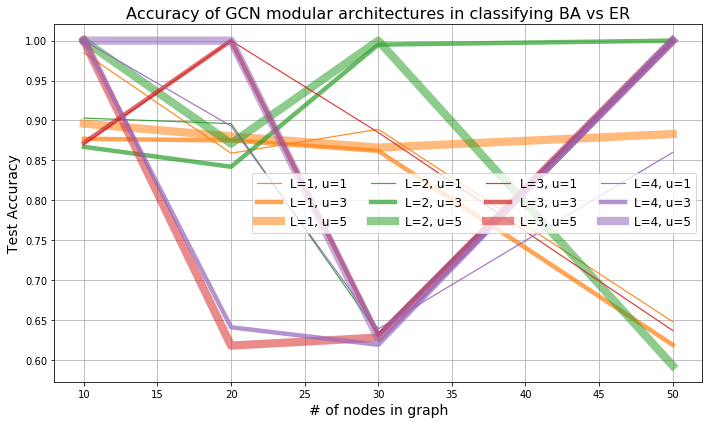

In [16]:
tempa = results.copy()
plotgraph(results)

In [20]:
#Generate the map dataset for BA vs CG
def generate_BAvsCG(params):
    map_dict = {"BA" : 1, "CG": 0}
    n_classes = len(map_dict)

    graphdatabase = GraphData(params["n_samples"], params["nodes"])
    graphdatabase.generate_BAGraphs()
    graphdatabase.generate_configurational_graphs()
    graphdatabase.generate_adjs()
    for i, adjs_a, adjs_b in zip(range(2500), graphdatabase.graphadjs[:2500], graphdatabase.graphadjs[2500:]):
        graphdatabase.graphadjs[i] = trim_mat(adjs_a, adjs_b)
    graphdatabase.tokenise(map_dict)
    
    ADJ = np.array(shuffle_graphadjs(graphdatabase.graphadjs))
    Y = np.expand_dims(np.array(graphdatabase.tokenisedgraphlabels), axis = 1)
    h = np.ones(ADJ.shape[:2]+(1,))
    return ADJ, Y, h

In [21]:
nodes = [10, 20, 30, 50]
layers = [1,2,3,4]
units = [1, 3, 5]
results = {}

for node in nodes:
    results[node] = {}
    print("Current node is :", node)
    for layer in layers:
        results[node][layer] = {}
        for unit in units:
            results[node][layer][unit] = {}
            print("Working for Nodes :", node, ", Layers :", layer, " and Units", unit)
            
            #Make the parameters for the model and the data
            params = {"n_samples" : 2500,
                  "nodes" : node,
                  "units" : [unit]*layer,
                  "activation" : "linear",
                  "outputnodefeat" : 10,
                  "inputnodefeat" : 1, 
                  "skip" : True}
            
            #Generate the data
            ADJ, Y, h = generate_BAvsCG(params)
            #Make the model
            net = ModifiedModularGCN(2, params)
            
            #Define the loss function
            loss_fn = nn.CrossEntropyLoss()
            #Define the optimiser
            optimizer = optim.Adam(net.parameters(), lr=.01)
            #Define the training step to train the model
            train_step = make_train_step(net, loss_fn, optimizer)
            #Make the dataloader
            train_loader, val_loader = make_loader([ADJ, h], Y, None, .2)
            #Train the model
            training_losses, validation_losses, training_accuracy, validation_accuracy = \
            train_model(net, device, train_step, loss_fn, 100, train_loader, val_loader)
            
            #Save the model results
            results[node][layer][unit] = {"loss": training_losses, "val_loss" :validation_losses, \
                                  "train_accuracy": training_accuracy, "val_accuracy": validation_accuracy}

Current node is : 10
Working for Nodes : 10 , Layers : 1  and Units 1


NameError: name 'configuration_model_1' is not defined

In [107]:
tempb = results.copy()
plotresults(tempb)

Populating the interactive namespace from numpy and matplotlib
(1.0, 1.0)
[[10.          0.605     ]
 [20.          0.629     ]
 [30.          0.671     ]
 [50.          0.72400004]]
(1.0, 3.0)
[[10.          0.597     ]
 [20.          0.58000004]
 [30.          0.65400004]
 [50.          0.628     ]]
(1.0, 5.0)
[[10.          0.60700005]
 [20.          0.637     ]
 [30.          0.74200004]
 [50.          0.725     ]]
(2.0, 1.0)
[[10.          0.61300004]
 [20.          0.754     ]
 [30.          0.81000006]
 [50.          0.694     ]]
(2.0, 3.0)
[[10.          0.66400003]
 [20.          0.771     ]
 [30.          0.67600006]
 [50.          0.771     ]]
(2.0, 5.0)
[[10.          0.628     ]
 [20.          0.75100005]
 [30.          0.71800005]
 [50.          0.845     ]]
(3.0, 1.0)
[[10.          0.69600004]
 [20.          0.794     ]
 [30.          0.85300004]
 [50.          0.827     ]]
(3.0, 3.0)
[[10.          0.73      ]
 [20.          0.749     ]
 [30.          0.836     ]
 [50.

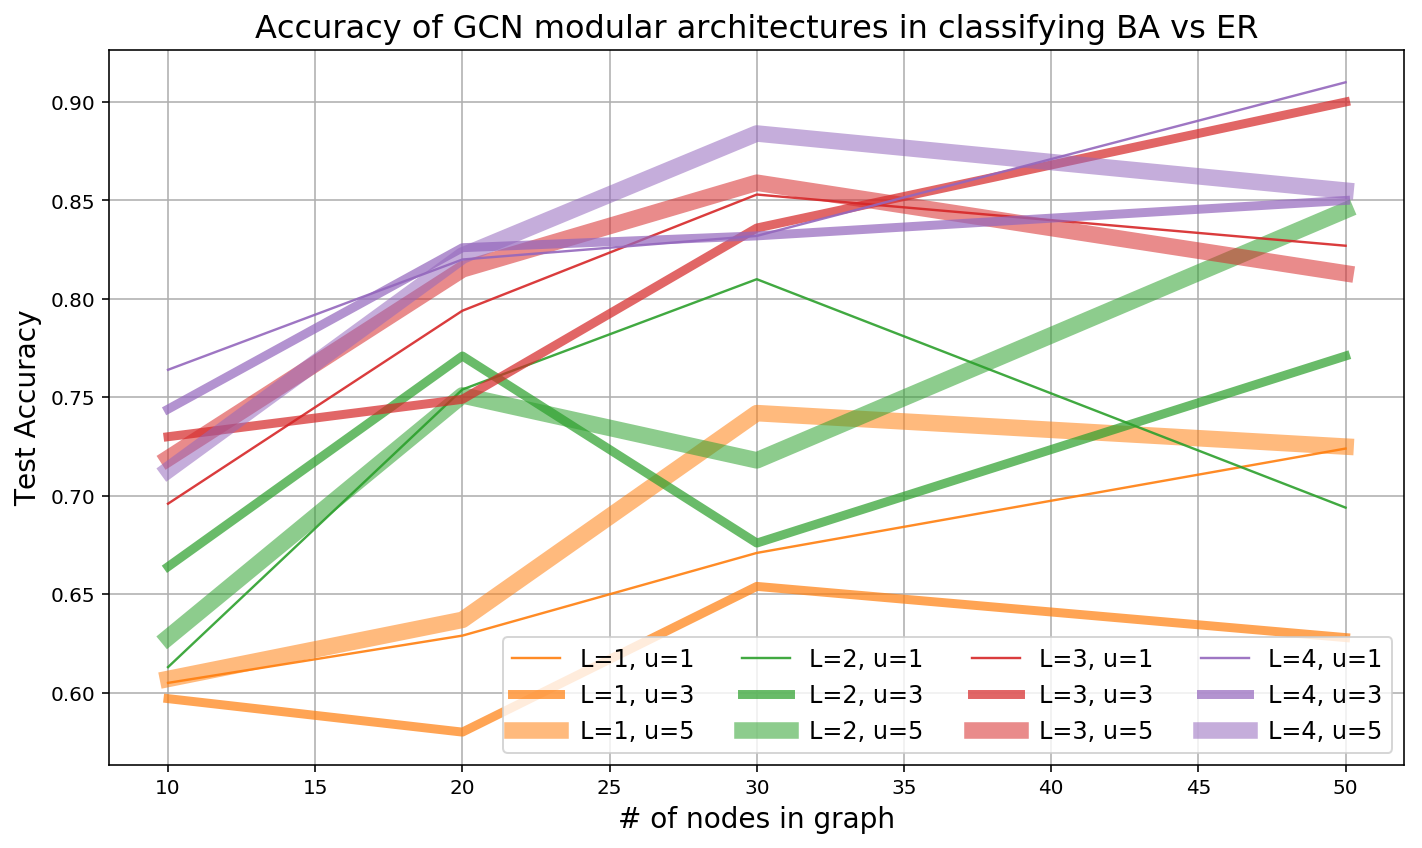

In [114]:
cols = dict(enumerate(mpl.colors.TABLEAU_COLORS))
figure(figsize=(10,6))
for k in sorted(stats):
    a = array(stats[k])
    l,u = k
    if l==5: continue
    plot(*a[argddsort(a[:,0])].T, label = 'L=%d, u=%d' %k, lw=1.2*u**1.2 , alpha= 1-tanh(u/10), c = cols[l])

legend(ncol = 4,fontsize=12)
xlabel('# of nodes in graph', size = 14)    
ylabel('Test Accuracy',size = 14)

t = ('BA vs ER' )
title('Accuracy of GCN modular architectures in classifying %s'%(t),size=16 )
grid()
tight_layout()